In [118]:
### <<< 위에서부터 순서대로 왼쪽의 화살표 버튼을 눌러주세요.
!pip -q install langchain-groq

In [119]:
test = {}

In [120]:
### 강의평 데이터 로드

rawCourseReview = """4, 팀 잘 만나면 재밌는 강의, 잘못 만나면 큰일 나는 강의. 카메라 한 번도 안 잡아본 사 람을 위한 강의. 포트폴리오 쌓으려고 들었는데 크게 의미 없었다. 교수님은 좋으심!!
2, 학생들이랑 직접 소통하다보니 학생들이 미화해주지만 교수님 강의력도 안좋으시고 학생 이메일 무조건 씹으시고 기분파시고 학점 잘 주시는 것도 모르겠다. 팀원 별로 여서 고생은 고생대로 하고 학점은 잘 못 받음. 다음에 고영제 들으려고 했는데 그냥 인턴이나 동아리 알아봐야겠다고 다짐하게된 수업 ㅎㅎ
1, 후반 비대면 되면서 학생한테 모든걸 다 떠넘김. 성암관 스튜디오에서 촬용 못하니 알아서 자취방이든 파티룸이든 구해서 찍어와라~ 장비대여, 장소 대여 비용 학생이 부담함. 코로나 2+알파 시기에 장소 대관 해서 조원 9명이랑 밀폐된 공간에서 3시간 이상 촬영함. 스튜디오 촬영 취소 된 날 하신 말씀 : 이제는 유튜브 시대다. 유튜브 형 식으로 찍어와라... ㅋㅋㅋㅋㅋㅋ크성적 후하게 줘도 미화가 안됨. 교수님 너무 무책임함. 이번학기 최악의 수업.
5, 능력자들에 치이고 가는 수업이었다 교수님도 츤데레처럼 챙겨주셨고! 마지막 과제인 영상 만드는건 정말 힘들었지만 성적잘주셔서 미화... ㅎㅎ 솔직히 편집을 한번도 다뤄보지않은 사람들은 편집을 몇 번 해보고 수강하는것을 추 천한다. 마지막 기말영상에 모두가 편집을 해약하는 상황이 올 수도 있기 때문이다. 수업에서는 편집을 기초부터 배우지 않기 때문에 열정만으로는 커버가 불가능한가요 같다. 어느 정도 감각이 있는 사람이 수강하는 것을 추천한다! 그리고 프리라이더는 제발 들을 생각하지 마세요
3, 방송프로그램 제작 관련 실습을 해볼 수 있는 좋은 수업. 시험은 없고, 수업시간에 교 수님이 준비하신 대본으로 실습연습하고 평가하고, 개인 과제는 기획서 제출이랑 레 포트 하나 있었고, 한 학기동안 팀별로 방송프로그램영상 하나 만들면 끝! 팀별로 촬 영할때는 스튜디오까지 직접 만들어야 되고, 여러모로 빡센 점이 없지 않아 있었지만 기억 남는 수업! 방송사 취업, PD 쪽에 관심있거나 프로그램 제작 과정에 대해 경험해 보고 싶은 사람이라면 이 수업 좋을 듯. 이제는 녹화 실습도 중계차로 해서 중계차도 타볼 수 있음!
4, 조 운이 정말정말 중요하다. 프리라이더는 제발 들을 생각 하지 마세요. 자기 조 촬영 하는 주랑 편집이랑 공부랑 병행해야하는 기말에 좀 빡셀 수 있으나 평소에는 시험도 없고 과제도 부담 없어서 나름 꿀이었던것 같다. 스트레스 받으면서도 너무 재밌었어 서 추천!!
5, 꿀잼수업~ 워낙 영상.방송에 관심이 많아서 한학기 동안 재미있게 보낸 것 같음~ 좋 은 사람들도 만나고 편집 실력도 늘음. 학점도 잘 주시는 듯
5, 교수님 너무 좋으시고 수업도 재밌다. 다만 학기말에 조별로 최종 영상 과제를(30분짜리) 만들어야 하는데 영상 한 번도 안 만들어본데다 프리라이딩까지 하는 조원들 때문에 힘들었음 조원 잘못 만나면 최악의 수업
4, 조모임이 정말정말정말 중요한 수업입니다. 사실 결과물들에 엄청나게 큰 차이는 없 기 때문에 명확한 평가 기준이 어떻게 되는지는 잘 모르겠지만 마지막 프로젝트를 완 성하는 데에 드는 시간 및 노력이 엄청나기 때문에 조원들 모두가 열심히 해야만 그 나마 수월하게 프로젝트를 진행할 수 있습니다. 개인적으로 시간적으로 널널한 학기 에 듣는 것을 추천합니다..
3, 수업자체는 즐거웠는데 조모임이 매우매우매우 힘들고 지각을 절대절대 싫어하셔서 9시까지 늦으면 안됨
1, 힐링강의? 절대 아님 음악사에 관심 없으면 듣지마셈 시키는 것도 많음 너무 귀찮아서 드랍한다 ㅂㅂ
2, 교양 주제에.. 할 게 많다.. 음악사를 너무 사랑하시는 거 같지만 그 사랑을 우리가 못 따라가겠다
1, 그냥 듣지 마세요 원래 음악사 잘 알던 사람인데 수업도 수업인데 시험이 개별로에 요. 기말에서는 곡 악장 숫자바꿔서 문제내는 등 자세하게 안 하면 틀리게끔 시험내 놓고 시험 쉽게 냈다 그러고, 이미 중간 어렵게 내서 절평 기준도 엄격하게 했을때 에 이권이 10퍼도 안되었는데 그냥 절평 학교에서 내려온대로 처리하신다고 하셨습니 다. 교수가 학생입장을 모르고 학점 잘 줄 생각보다 자기가 가르치는걸 전부 알지 못 하면 안된다는 입장이시니... 학점 좋게 받으면 꿀인 교양과는 전혀 맞지 않습니다. 다른거 들으세요 진짜.
1, 이 수업 시험 뭐야•····•과제도 많아요.절대 선택하지 마십시오!!!
3, 빡쳐서 쓰러왔음. 유익한 건 맞는데 교수님 너무 깐깐하심.. 교양에서 전공 이상의 노 력과 전문성을 요구하시는 거 같아 솔직히 너무 힘듦. 시험성적 그럭저럭 나온거? 아무 소용 없을 거 같음. 글쓰기 과제에서 꼬라박을테니까
5, 꿀강이에요 잔과제 많지만 얼마 안걸리고 편함 시험도 중간은 개꿀
4, 연주회도 갈 수 있는 좋은 기회였음. 중간은 오픈북이기 때문에 부담은 없지만 기말은 클로즈북이라 공부 어느 정도 필요
4, 에쁠은 좀 빡셈. 그러나 족보 구하면 그 이하부터는 매우 수월함. 족보 여러개구해서 많이 풀어보는거 추천. 과제도 적당했고 음악회 다녀올 수 있는 기회도 돼서 좋았다.
5, 재밌었습니다. 계절로 수강하는 거 추천! 족보 꼭 구하시고요~
5, 합창 개인적으로 재미있었음~ 얘기하는거 좋아해서 토론이 좀 더 많았으면 더 재미있었을 듯 ㅎ 과제도 적고 서양 음악사에 대해 배우고 유익했다.
2, 정말? 정말 들어 이거? 한번만 더 고민해봐....
4, 사이버 강의임에도 불구하고 열심히 수업하시고 학생들과 열심히 소통하려고 하셨습 니다. 중간은 대체과제로 진행되었고 기말은 서술형 두문항으로 출제되었는데, 시간 이 매우 부족했습니다. 그래도 만족하는 강의입니다.
2, 여기 후기 남긴 사람들 말 무시하고 피피티 얼마나 많겠어~ 하고 신청했다가 지금 피 눈물 흘리면서 기말고사 봅니다. 내용은 재밌고 교수님 너무 친절하시고 학생들을 좋아하시는게 보이는데 시험이 오바에요. 분명 중간고사 이후 범위인데도 중간고사 대비 기말은 1.5-2배정도 분량이 늘어난 느낌입니다....
5, ppt많습니다. 범위는 평범합니다. 시험은 쉽습니다. C+받았습니다.
2, 범위가..........진짜......너~~~~~~무 많아요....하...... 20 피피티 보다 토할듯.....
4, 암기 못하는 편이라 개고생함 풀마 때리고 들은 강의였는데 개후회함 개열심히 했는 데 에마 받음 중간 기말 퀴즈 전체에서 한 10~15개?틀렸던 듯 교수님 자체는 너무 좋으신데 시험 특성상 학점 따 가긴 어려움
3, 중간 19/35 기말 30/35 최종 C+나옴. 재수강 갑니다.
3, 내용 흥미롭고 과제 없어서 부담없이 들엇어요. 평균보다 살짝 낮았는데 C+임 ㅠ
5, 여러분 시험이 쉽게 나오는 것은 안정적, 외부적 귀인 요인입니다. 저 이거 틀려서 너 무 슬펐어요 이거 기억하고 가세요ㅠㅠ 97.5점인데 a+ 못받으면 불지르려고요
1, 매주 퀴즈도 있는데 가르쳐주지 않은 곳에서 나올때도 많아요. 시험방식도 도중에 바 뀌고 불합리한 수업운영이 이루어질 때도 있었습니다. 학점도 나누어주시니 웬만하 면 다른 쁠몰 강의를 찾아서 듣는게 좋을것 같아요!
2, 3시간 내내 듣기평가+받아쓰기 대회 교수님 랩하시는거 잘못 알아들으면 끝임 열심히 듣고 필기했다고 호소해도 소용없음 애초에 에이쁠 잘 안주신다고 말씀하셨고 본인 총점 94.67인데 에이제로 받음 열심히 한 만큼의 보상 바라는 사람한테는 비추 내용이 그닥 새롭거나 유익하지도 않음
3, 시험 두 번(오픈북) 조모임 한 번 수업 내용이 새롭다거나 어렵다거나 하지 않고 평이하고 살짝 지루할 수 있어요 그래도 교수님 넘 좋으시고 워트있으세여 조모임은 수업 내용을 대중매체와 엮는 거였어요 피피티 외에서도 시험을 내시니 좀 강조하시는 수업 내용 필기 필수! 필수과목일텐데 들어볼만 합니다
5, 학생들과 친하게 지내고 싶어하는 교수님의 마음이 너무 따듯하십니다! 성적은 정말로 객관적이시지만 후하게 주시는 거 각습니다:) 티타임 언제든 신청해보세요!
3, 대인커뮤니케이션 이론들을 넓고 얕게 알아가는 수업이에요. 어렵지 않지만, 조금은 지루하다고 느꼈습니다. 교수님은 좋은 분이십니다. 학생들과 가까워지려고 많이 노력하세요. 시험은 수업 중 필기를 꼼꼼히 하는 게 중요합니다. 성적은 무난합니다.
5, 수업 내용 쉽고 팀플도 조원들 잘 만나면 무난무난해요. 시험 오픈북이라 피피티 자료 외의 강의내용도 꼼꼼히 필기해둬야 좋습니다! 수업 자 료 + 필기 정리만 잘 해놓으면 성적 잘 받으실 수 있을 겁니다.
3, 수업 내용 어렵지 않고 무난한 전필인건 맞는데 점수컷이 너무 극악.. A+가 2명이면 컷 조금 낮춰주실 수 있는 거 아닌지ㅠㅠ 아래 강의평처럼 받아쓰기 잘해야함 시험 잘보려면 그냥 교수님 말씀 다 받아적으세요
4, 시험보고 팀플이 있는데 조별 상호 평가가 있습니다. 교수님께서 얼마나 상호평가점 수를 반영하시는진 모르겠지만 성적은 잘 나왔어요
3, 강의가 특별히 흥미롭지는 않음 이론이 많아서 단순 이론 공부하는 것 같음 교수님은 착하고 좋으심
5, 에이쁠은 빡세지만 그 아래부터는 컷 매우 널널해요 과제는 한 번에 30분도 안 걸리 는 간단한 과제들이고 사실상 수업시간 필기 싸움 조별 과제는 좀 빡세지만 조원 잘 만나면 할만해요
4, 이번 학기 젤 배울 점 많았던 수업. 나 자신과 나의 대인관계에 대해 돌아보면서 반성 도 하고 이해도 하게 되는 좋은 시간이었습니다. 교수님 강의력도 좋으시고 저는 다 시 돌아가도 다시 듣고 싶을 정도로 강의 내용이 너무 좋았습니다. 다만 성적 기준이 매우 깐깐하세요 이번 학기 a+ 2명 주셨다고 합니다.. 그 기준도 모르겠지만. 뭐 a 권대는 많이 주셨다고 하니 a 노리시는 분들은 추천.. 성적 아니더라도 저는 이 강의 꼭 들어보셨으면 좋겠어요 ㅎㅎ 언홍영 수업 중에 젤 재밌었어요
2, 광이 vS PR론 진짜 언홍영 전필 세계관 최강자들의 싸움이다...
2, 교수: 제가 좀 까다로운 편이에요. 제 수업 스타일이 마음에 들지 않으시면, 다른 수 업을 들으세요. 우리과에 다른 좋은 수업들이 많아요~" 삼사천단위 졸업요건+전필이라 듣는 학생들:...????
1, 개인적으로 언홍영 수업 중 최악의 강의로 손꼽겠습니다^^ 1. ﻿﻿얻어가는 게 없음 (PR개념 정도나 알게되면 다행) 수업을 무슨 참여형이라고 해서 계속 지목해서 질문하는데 진심으로 그게 도움이 안 됨. 그냥 시간만 줄줄 간다. 2. ﻿﻿그지같은 조모임 진짜 조모임으로 할 말이 많은데, 일단 전체에서 40%가 조모임 점수임. 게다가 중 소 모임 랜덤 배정으로 조 정하고 그 조랑 파이널 프로젝트 하라고 함. 말 되냐고요. 외국 인은 그와중에 많아서 외국인들꺼 한국인들/조장들이 다 했다고 들었음. 3. 프로젝트 내용 뭐 알려준 걸 바탕으로 뭔가를 해내는게 아니라 그냥 PR 중에서 주제를 정하고 학생 들이 lecture를 진행하는거임. 개론 수업에서 학생들보고 대체 월 가르치라는 걸까요. 당연히 발표 퀄 다 낮고 얻어가는 게 없는 무의미한 시간. 4. 교수의 소통 전혀 소통이 안됨. 언제 시험 문제를 공유하기로 했는지 까먹고, 프로젝트에서 페이퍼 를 제출하는 건지 아닌지 까먹을 정도로 수업에 애초에 관심이 없음. 맨날 정신없고 바쁘고 직접 메일도 하지말라고 하고 조교한테 메일 보내라고 공지 띄움. 그정도로 학부 수업에 관심이 없으면 대학원 수업만 하던가 필드에서만 일하셨음 좋겠다. 5. 성적 이렇게까지 개고생을 했으면 마지막에 성적이라도 잘 주는게 인지상정이라고 생각하 는데 비율을 채우는 걸 넘어서서 걍 짜게 주는듯. 심지어 항목별 점수도 공개 안 함. 자림의 염전 ㅋ 덕분에 평균 뚝 떨어짐 그냥 싫다 개싫다 얻어가는 것도 없고 도움도 안되고 시간 투자만 많이하고 고생하고 마지막에 성적까지 그지같다 교수가 바뀌든 폐강을 하던 했음 좋겠다 ㅈㅂ
2, 일단 아랫분 말 다 받고요 진짜 얻어가는 거 아무것도 없음 교수님이 매우 바쁘고 정신이 없어 보이심 조교가 불쌍함 중간고사 : PR관련 영화 보고 감상문 쓰기 기말고사 : 에세이형 문제(3일정도 중) 조별과제 : PR 부문 중에 하나 정해서 강의하기 조별과제가 비중이 제일 조원들 잘못 만나면 됨. 그리고 인트로 피알인데 학부 생들이 뭐 아는 게 있다고 렉쳐를 시키는지도 모르겠고 ~ 초반에는 피알 개념 관련해 서 가르쳐주시기는 하는데 그것도 절반은 조별활동이었음. 후반에 조별과제 빼고는 딱히 과제도 없고 그다지 어려운 내용도 아니어서 그렇게 힘든 과목은 아닌데 .. 그냥 정말 얻어가는 게 없다 다들 전필이라서 듣는 듯
5, 악플들 보고 수강 걱정했었는데 그냥 못하신 분들의 부들부들이었네요. 성적도 후하 게 주시고 세부성적 마지막에 안내되고 과제도 하나도 없고 조모임은 좀 걸리지만 평균 수준입니다. 수업도 토론형이라 재밌고 편해요. 배울 게 없다고들 하는데 딱 개론에서 다를 만한 정도입니다. 근데 겨우 이거 하는데 에이쁠 못 받고 나서 배울 게 없다 고 얘기하진 않겠죠 설마. 또 제발 대학생정도 됐으면 조별 토론에서 적극적으로 나서시길. 참여 안하고 뚱하게 있으면서 참여형 수업 도움 안된다하면..
1, 최악•••비추 전필 아니면 절대 선택하지 않습니다 ㅋㅋ
2, 참여형 수업을 지향한다는데 진짜 도움 하나도 안되고 평가 방식도 진짜 이해가 안 감. 조모임 조원평가도 아니고 왜 전체 수강생이 다른 수강생을 평가하는 시스템을 넣었을까 개론이면 개론답게 배우는게 있어야 되는데 학기초에 찔끔 가르치고 학생들한테 강 의하라는 게 맞는지도 모르겠다 성적 나오는 날까지 그 어떤 점수도 안 알려주고 그냥 letter만 띡 던져주는데 걍 별로 임 3천단위에 전필이라 듣는거지 이 수업으로 뭘 배울 생각은 ㄴㄴ
5, 강의평이 이렇게나 안 좋은 이유를 모르겠네요. 저는 너무 재밌게 잘 들었고, 한국 대학교에서 이런 재밌고 열정적인 참여형 수업을 할 수 있게 되어서 너무 기뻤고 신선 했습니다. 성적 관련된 부분은 좀 애매한 점이 있지만, (과제 점수나 기말 성적을 알려 주시지 않았어요 ㅠㅠ) 나쁘지 않게 주시는 것 같습니다. 언홍영 강의 많이 들어봤는데 전 정말 만족한 강의였고 학우들과 친해질 수 있어서 좋았습니다. 다만 친구가 없거나.. 친화력이 부족하신 분들은 어려울 수도 있겠다는 생각이 듭니다.•••• 열정만 있다면 정말 좋은 강의!
4, 한 학기 동안 편하게 들었고 1번 있는 시험도 take home 오픈북이라 좋았어요. 성실하게만 임하면 성적도 잘 주시는 것 같고, 중간중간 현직자 특강도 있어서 유익했습니다. 저는 아니었지만 PR에 관심 있는 사람에게 더 잘 맞을 것 같아요. 강평 때문에 좀 걱정했었는데 참여형 수업이라 덕분에 친구들도 사귀고 좋았습니다! 매번 타임어택 느낌으로 토의가 진행되는 건 약간 아쉬웠습니다.
4, 악평이 자자해서 얼마나 힘든 수업인지 걱정했지만 생각보다 나쁘지 않았음 이번에 는 중간은 영화보고 보고서 기말은 걍 시험 밧는데 연출에 나온거랑 똑같아서 크게 부담은 없었고 학기중에 조별과제가 조금 준비해야될거 많았지만 조원들이랑 잘 맞 춰서 진행했음 조원을 잘 만나야 되는것 같고 그냥 뽑기로 조가 추첨된거라 그냥 내 운이라고 생각하면 됨 수요일은 동영상 강의였는데 가끔 숙제를 주셔서 까먹지말고 런어스에 올려야함 아직 성적은 안나왔지만 조별과제 절때 프리라이더 못한다 왜냐 하면 조원 상대 평가라서 내가 한만큼 점수 주는듯 나는 잘하고는 싶었지만 기여도가 낮아 어떻게 될진 모르겠다. ; 그리고 학생 전체가 모든 학생을 평가해서 요건 좀 변수 일듯 그래서 강의하실때 열심히 발언해 학생들이 이름을 기억해야 될것 같다 나 는 솔직히 존재감 업는 학생에겐 오점만점에 사 줬다 그리고 다 5점 줬음 백퍼 참여형 수업이고 내향적이다 but관종이다 하면 수업이 재밋을것 같다 수업때마다 급하게 조를 만들어 토론하는데 어차피 애들마다 지정석이 있어서 그 친 구들끼리 수업때 자주 말함 중간에 현직자 특강있었는데 좋았다 교수님이 영어 좋아해서 수업자료도 영어였는데 나는 영어 못하지만 눈치껏 하면 할만 했다
2, 수업이 매우매우매우X9999999 비효율적임. 속터져 죽는줄 알았음. 출석체크 안된 학생들 이름 한명한명 부르는 것 부터 총체적 난국의 기말시험까지. 밑에 평가 하신 분이 자세히 써서 말은 안하겠음. 시험 난이도는 그냥 그럼. 문제는 족보랑 거의 일 치하고 조금 더 추가됨. 성적은 나와봐야 알겠지만 참..의미없는 한학기였음.
1, 대형강의라 그런지 빌런도 많고 교수님 수업은 맨날 산으로 가고··· 뭘 배운건지 도무지 알 수가 없네
5, ㄹㅇ 코로나학기 수업중 역대급 꿀강ㅋㅋㅋ 매번 강의 듣고 막판 출석퀴즈만 풀면 끝이고 과제 시험도 없었던..그치만 강의 내용이 넘 재밌어서 수업도 재밌게 들었습니다 진짜 꿀교양이니까 강추
1, 진짜 그냥 듣지 마세요. 정말 인생의 최대 시간낭비라고 느껴지실 거에요 교수님 학생들 피드백 안 받아주시고, 매번 출석 안 한 학생 이름 체크하시고, 위잉 소리 나고, 정말 답답합니다
1, 1학점같은 로드와 진도 강의계획서대로 진도 안 나가고 지각 찾으심. 교수님께서 수업을 그리 신경쓰지 않는 게 느껴져요
5, 교수님 정말 친절하세요! 근데 학생들이 좀..대형강의라 그런지 예의없고 찡찡대는 사람들 많아요. 그래도 유익하고 즐겁게 들었습니다
3, 교수님께서~~ 강의보다는 다른 업무에 정신과 마음이 가 계신 것 같아요~~~~ 3학점이지만 1학점으로 느껴질 만큼, 로드가 적었어요 화,목요일 수업이었는데 목요일에는 아예 강의가 안올라옴•·(오히려 좋아) 퀴즈(중간성적 대체),출결, 기말로 학점이 결정나는데 기말은 시간이 촉박할 뻔 했다. 비대면 프리미엄을 제대로 누렸던 수업
4, 비쁠·•• 잘 봤다고 생각했는데••• 흠••• 수업 내용 쉽고 교슈님께서는 엄청 프리하세요~
5, 이번 학기 들은 교양 중에 제일 좋았습니다ㅠㅠ 교수님도 너무 착하시고 중남미로 여행 가고 싶어지는 수업이에요ㅠ 과제도 없고 중간기말만 보면 돼서 다른나라 역사 나 문화 배우는 걸 좋아하고 암기에 거부감만 없다면 최고의 수업같아요!
4, 개인적으로는 무난무난했던 강의라고 생각됨. 중간중간 영화 혹은 영상시청 그리고 느린 수업 진도로 인해서 수업계획서에 나오는 것의 60%?정도만 하신듯함. 그래서 뭔가 엄청 많은 내용을 배웠다라기보다는 라틴아메리카라는 지역의 역사와 지역문화 등에 대해서 포괄적으로 배울 수 있었음. 그렇기 때문에 교양과목으로는 적당한 정도 라고 생각됨. 또한 거의 매주 퀴즈가 있지만 난이도가 어렵진 않아서 부담도 없었음. 다만 아쉬운 점은 대형강의임에도 교수님과 조교님 한 분만이 시험을 관리하셔서 좀 미숙한 점이 많았다는 점... 어차피 오픈북이고 중요하게 말씀하신 부분들에 대해서 시험이 많이 나왔기 때문에 컨닝의 가능성으로 인한 불합리함은 크게 없었으나 시험 관리 부분은 좀 개선해주셨으면 좋겠음. 아 그리고 시험보는데 마이크 켜서 질문 좀 안하면 안 되나? 물어볼수도 있는 질문도 있긴 했지만 쓸데없는 것도 많아서 셤 보는 데 살짝 짜증났음.
5, 솔직히 평에 비해 진심 괜찮았던 수업ㅋㅋㅋㅋ 대면도 수업 내용은 안 듣고 그냥 가서 앉아있으면 되고 퀴즈는 강의 영상 안 봐도 강 의안만 뒤적거리면 풀 수 있는 수준임. 시험도 아주 잘 본 편은 아니었는데 에제 떴어 요 동강+대면 출석 잘하고 족보랑 강의안 띄워놓고 시험 때 컨 잘하면 에이권은 뜸 학점 후하심 교수님이 매년 족보랑 똑같이 문제를 내시는 게 아니고 말을 바꿔서 내시니까 족보랑 내용 겹친다고 해서 무조건 똑같이 답 찍지 마시고 시험 문제 꼼꼼하게 끝까지 읽어 보세요
4, 대면 강의가 불편하게 느껴질 수도 있습니다 학점은 확실히 널널하게 주시는 듯 출결은 전자출결+지정석입니다 대면 때 종종 퀴즈도 있어요
4, 대면 때 매우 정치색이 강하시지만 본인은 정치색 강하지 않았고, 지식이 많으신 게 느껴져서 대면 강의도 흥미롭게 들었음 성적도 너그럽게 주시는 편 시험 문제가 요상해서 점수도 이상하게 나오지만 조절을 많이 해주시는 듯. 과제 없 고, 비대면 팀플? 진짜 소감 적기같은거 한번 나름 꿀강 + 명강
3, 이렇게 대면 시간에 마음이 불편한 강의는 처음, 이 교수님 수업은 절대 다시 안 들어 야겠다고 다짐했음 성적은 잘 주심!
5, 중간 기말 비대면 시험 2번 대면 수업 퀴즈 아마 7번? 조별 과제 하나 + 출석으로 성적이 나옵니다. 동영상 강의 듣고 대면 강의 1시간 들어요. 교수님 강의력 좋으세요. 교수님 대면 강의 때 정치 성향이 다르면 조금 불편할 수 있는데 듣다보면 합리적이에요. 중간기말 150이상 퀴즈 하나 틀리고 출석 만점이면 학점 잘 주세요. 시험 유형이 단어 하나로 틀리는 내용인 문제들이라 함정이 많아서 점수 보고 다들 놀라요... 그래도 이데올로기에 대해 많이 배울 수 있어서 좋았어요. 개인적으로 추천합니당.
3, 온라인 강의는 상당히 유익하고 교양다운 수업이 진행된다. 다만 실시간 강의에서는 정치색이 강하게 느껴지는 발언을 자주 하시며 학생들에게 그리 친절하진 않다. 조교 님도 교수님을 상대하느라 힘들어보였다.
2, 교수님께서 학생들에겐 각박하고 자신에겐 매우 너그러우심. 수업 시간에 기습 질문했다가 대답 못하면 공개적으로 망신주고 점수 차감함. 매수 업시간 지목당할까봐 공포였음 반면 하루는 수업시간 20분 지각하셨는데 그거 무마하려고 조교한테 전화 걸어서 스 피커폰으로 돌발퀴즈 내심 전화하며 당당히 강의실 들어오던 그 모습을 잊지 못함. 동강은 매우 깔끔하고 강의력도 좋으신 반면 대면수업은 배우는 것도 없고 그저 자신 의 정치적 성향 설교를 위한 시간. 매주 돌발 퀴즈도 있음 물론 자기 얘기에 심취해서 시간 다 가고 급하게 끝내느라 못 낼 때도 많음. 점수 잘 준다고 해서 그거 하나 보고 버텼는데 점수도 그렇게 잘 주시는지 모르겠음. 나름 열심히 공부했는데 차라리 공부 안 하고 ctrl+f로 잘 찾을 수 있게 정리해놓는 게 나을듯. 개인적으로는 너무 고역이었으나 팀플 없고, 과제 없고, 로드가 매우 적다는 점에서 대면 1시간 잘 버티고, 족보 잘 구해서 시험만 잘 본다면 이만한 꿀강도 없긴 할 듯
5, 동영상 강의 잘 듣고 시험 전에 노트 3회독하면 A+ 가능..
5, 개꿀임 정말 아무런 노력없이 출석만으로 B+을 받음 노력을 한다면 A+도 가능
5, 수업 재밌고 시험 문제는 좀 헷갈리지만 학점은 너그럽다. 교수님도 알고 보면 따뜻 하신 분이다.
5, PPT 분량에 쫄지 말고 자기만의 방법으로 열심히 공부하면 충분히 좋은 성적 받을 수 있습니다. 기본적으로 성적 컷이 낮아요. 그리고 공부해둔 내용들도 나중에 법 공부 할 때 써먹 기 좋습니다. 다만 교수님 강의력이나 PPT 가독성이 매우 떨어진다는 점 유의하시길 바랍니다••·
5, PPT 범위가 악랄하지만 그것만 버틴다면 성적은 잘주는 강의
3, 조별과제나 별도 과제 없이 중간기말 시험2번+출석으로 평가 끝입니다 컷도 그렇게 빡세지는 않은 것 같은데 문제가 어려워요
5, 법과목 특성상 양이 꽤 많습니다 저는 중간때 평균 +10점, 기말때 공부를 제대로 안해서 평균 10점 받았는데 에제 떴어요 쌩암기에 자신있으시면 성적 잘받으실거에요
5, 오로지 시험만 있는 과목 대신 학점을 잘 주시는 편이에요 헌법 기출 이런거 안봐도 에이 나옵니다 (기억 안나지만 전 평균보다 30-40점 정 도 높았던거 같음) 하루이틀 벼락치기 함 양이 많긴 많은데 할 수 있습니다
3, 그냥 듣지 마세여..... 법에 큰 뜻이 있는 게 아니라면..... 객관식 시험 두 번 보는데 문제 난이도 상상을 초월하고 문제 길이도 긴데 부정행위 방지한다고 타임어택이라 그냥 읽지도 못하고 찍음.. 한법을 이해함으로써 한국 정치의 기반을 알아보고 싶다, 그래도 한국인으로서 헌법 이 어떤 건지 알아보고 싶다는 생각으로 신청했는데 조항 수십개+정부 구조+임기 몇 년인지+무슨 투표가 부결되려면 몇 명 출석에 n/n 찬성이어야 하는지 등등 그냥 지식 백과 단순암기임... 의미를 찾고 사고하는 수업 듣고 싶으면 절대 LL. 그냥 생각없이 통암기하는 거 자신 있으면 ㅇㅋ 참고로 기말 범위만 피피티 670장이었음.. 강의도 거의 매번 3시간 넘음. 교수님 착하 신데, 착한 악마야ㅜㅜ 강의 들어도 이해되는 거 1도 없어서 그냥 어찌어찌 알아서 외워야할듯 결론은 듣지 말라는 말이야...• 로스쿨 준비하면 도움 될 수도..?
2, 아무리 학점미화라고 해도 할 말은 해야겠읍니다 일단 교양과목답지 않게 강의 로드가 너무너무너무너무 많습니다. 진짜 심하면 한 주차 강의에 교안 ppt(그것도 글로 꽉 찬)가 200장이 되는 것도 봤습 니다. 하지만 학점미화 하나만으로도 들을 가치는 있는 과목입니다. 저는 출결에서도 -2점 감점당했고, 중간 기말 모두 평균 이하였지만 AO를 받았습니 다. 학기때 고생하시더라도 좋은 학점 받고 싶으시면 신청하는 것을 추천드립니다.
1, 너무 별로.. 우선 강의력이 진짜 처참합니다 강의도 몇 개 재탕하시는 거 같고 말 끝 마다 ~라고 볼 수 있는거죠, ~라고 하는 거죠를 붙이시며 말 끝이 간결하지 않고 굉장 히 길게 늘어놓으셔서 더더 강의 알아듣기가 힘듭니다 분량도 진짜 너무 많아요 동영 상 강의 + 실시간 강의인데 동영상 강의만으로도 3시간을 꽉꽉 채우십니다 ppt는.. 범위 1회독 하는 것만으로도 시간 많이 써야하고 진 빠집니다. 했던 말 반복도 심하시 고 어..그러니까. 뭐라해야하죠 등등 수업 중간중간 끊기는 부분이 많아서 정말 강의 듣는 내내 힘들었습니다. 다시 수강신청 하면 다른 걸 잡겠습니다. 로스쿨 준비하시는 분들.. 다른 거 들으세요
1, 정말 비추 합니다!! 중간고사때 범위가 피피티 600장 정도, 기말고사때 범위가 700장 정도였습니다. 교양이라고하기엔 범위가 너무 많습니다... 강의력도 좋으신지 모르겠네요..
3, 학점미화만으로 3점 드림. 정말 한 학기동안 말도 안되는 로드로 고통받고 싶으면 들으세요.
4, 일단 과제 없어서 편하구요 근데 중간 보고서때 꽤 좋은 평을 받아서 기말 보고서도 비슷하게 형식에 집중해서 썼는데 B+ 받았습니다. 왜그런진 모르겠어요. 학점에 목메실 분은 들으시면 안되고 그냥 학교 편하게 다니실 분 들으시면 될 것 같아요 편하기는 진짜 편해요. 과제 다 합 쳐서 3시간도 안 했어요
4, 교수님 수업은 좋았습니다 과제도 다른 분반에 비해 적은 편이었고 몇개 있는 것도 한 10분정도면 금방 할 수 있 는 수준이라 학기중엔 편했습니다 팀플이 가끔 있긴한데 전 팀플 재미있게 해서 그건 괜찮았구요 제가 느낀 문제점은 ﻿﻿기말과제가 조금 빡센 편이었다 원하던 성적을 받지 못했다 교수님의 채점 기준을 잘 모르겠습니다 분명 기준이 있긴 하셨을텐데 마지막 기말레포트를 쓸 때까지 그 기준을 알지 못했습니다 그래도 교수님은 다정하신 분이셨구요, 전체적으로 부담이 큰 수업은 아니었습니다 수업때 교수님 말 하나하나 꼼꼼히 들으면서 알아서 기준 찾아나갈 수 있는 분, 또는 학점 욕심은 크게 없고 덜 빡센 글쓰기 수업 듣고싶으신 분께 추천드릴 수 있을 것 같아요
5, 아래 분께서 주제와 형식을 신경쓰신다고 하셨는데 제 견해는 수업 시간 내내 문장의 유기성을 강조하기도 하셨어서 내용 면에서도 유기적인 흐름이 중요할 것 같습니다. 짧은 문장, 올바른 문법(일본식 표현 쓰지 않기(예: ~적) 등), 접속사 (그리고 그러나 또 등등) 적게 쓰기 같이 수업시간에 교수님의 성향을 잘 파악하셔서 교수님 맞춤형 글을 쓰면 좋은 성적 받는 것 같습니다 .. 수신에 실패해서 들은 강의긴 하지만 김기란 교수님 수업을 들었기에 힘든만큼 남는 것도 있는 것 같네요. 다행히 시험이 없고 중간중간 과제가 간단한 수준이라 수업만 편하게 잘 들으셔서 글쓰시면 괜찮게 받아갈 거라 생각합니다 .. 아 같은 주제를 고른 사람끼리 모여서 자료조사를 하는데 은근 팀원이 중요한 것 같습니다.. 그리고 교수님께서 기말보고서 내는 기한을 최다한 늦춰주셔서 감사했습니다. 대학 글쓰기 제대로 배워갑니다.!
2, 평가기준이 너무 깐깐하고 1학년한테 바라는 기대치가 높으십니다.
4, 성적 잘 받는 팁? 살짝 적어봅니다. 교수님께서 글의 내용보다는 형식, 주제를 신경쓰십니다. 수업시간에 매번 강조하시 는 서론-본론-결론 형식, OREO 형식만 잘 맞춰서 제출하면 분량은 적어도(이게20 꿀) 좋은 점수 받으실 수 있어요. 평소에 글 많이 읽고 쫌쫌따리 적어본 사람이면 강추! 물론 아래 분들 하신 후기 다 맞음... ㅋㅋㅋ 그리고 교수님께서... 살짝... 음..... 연대 정교수가 아닌 외부강사시고... 꼰대 마인드 에... 학생 억까가 심하고... 수업 준비는 하다 만 것 같고... 혼잣말이 많고 부산스럽지 만... 다른 글쓰기에 비하면 매주 과제는 아예 없는 수준이니 편하게 들으실 수 있을 겁니다. 굿!!
3, 도대체 왜 에마인지 납득이 안가네요. 이의신청 하기도 겁나는게 교수님께서 워낙 글쓰기에 대한 프라이드가 있으신 분이라 절대 조정은 없을 것 같아서 하하.. 뭐.. 그렇습니다.
2, 나는 진짜 "글쓰기"가 무엇인지 뜯어 알고싶다, 편하게 듣고싶다 => 들으셈 성적이 조금이라도 상관있다 => 절대 듣지 마셈 노력과 1도 비례안하는 과목임
2, 아래 평가보니 현타가 더 쎄게 오네요. 저는 올출에 수업도 필기해가며 다 들었는데 성적이 잘 안나왔습니다.. 기말보고서 종강후에 5일 동안 쓰느라 힘들었습니다. 이번 학기 가장 노력을 많이 했으나 가장 낮은 학점을 받고 가네요.. 랜덤학점인 것 같습니다.
5, 글쓰기 수업 때 배운건 출처표기법 밖에 없을 정도로 수업 안들었습니다. 그리고 기 말 보고서도 그냥 하루만 투자하고 냈는데 에쁠 받았습니다. 솔직히 평가기준을 하나 도 모르겠는••• 걍 교수님 맘에 들 자신있게 글 쓸 수 있으면 듣는데 랜덤학점 무서우면 듣지마세요
5, 다른 과목 다 에쁠인데 이거만 비쁠 떠서 재수강하게 생겼네요. 저처럼 수신 실패하 지 마시고 다른 글쓰기 들으세요. 채점 기준도 불명확하시고 다른 과제 채점들도 전 부 튜터쌤이 하시는 듯 합니다. 과제를 내면 항상 학생 이름과 함께 화면에 띄워서 비판하시는데 멘탈 약하시면 힘드실 겁니다. 돔황챠..
1, 일단••• 교수님이 사회성이 너무 없음 단순 질문인데도 인간의 본성은 이래서 안 된다.. 뭐 이런 식으로 딴 소리 하다가 질문 의 답은 안 해주시고 ㅠ 사회성 없고 자기 세상만 살아온 느낌··· 불쾌해요
4, 학점미화 인정 근데 교수랑 안 맞아서 수업이 좀 힘들었음 수업 내용도 강의력도 좋은데 그냥 불쾌하다고 해야하나 인간적으로 굉장히 흥미로우신 분
5, 영민백 ㅠ 한학기동안 넘 귀여웠어요 코딩을 사랑하시고 자료 분석을 즐기시는 통계lover이십니다.. 중간고사는 수업만 열심히 들으면 고득점받기 쉬운 편이지만 기말고사는 이해도 힘 들고 오픈북임에도 개인적으로는 어려운 시험이었습니다 그래도 학점 미화 엄청 해주시니 걱정 말고 열심히 수업들으세요
5, 교수님 귀여우세여 강의는 명강인데 시험이 빡셈 서술형이 다임
3, 본인은 최종 성적 A+을 받았음에도, 이 강의가 불만족스러웠던 것 같습니다. 수업은 zoom으로 진행되었는데 3시간 연강 중 1시간마다 10분가량 쉬는시간을 주셨고, 중 간 즈음부터는 강의 녹화본도 모두 올려주셨습니다. 강의 내용도 제가 들은 여타 강 의와는 비교가 안될 정도로 유익하고, 정말 대학 수업을 듣는구나 라는 느낌을 받을 정도로 좋았습니다. 많은 논란과 잡음이 있던 시험문제의 경우, 단순 개념암기식이 아니고 개념을 정말로 이해했는지를 확인하는 문제들로 구성되어 있었으며 제 개인적 으로는 학업로드도 적고 채점기준도 너그러운 편이었다고 생각합니다. 그러나 진짜 문제는 교수님의 화법과 학생들을 대하는태도(감히 학부생으로서 태도란 단어를 사용하는게 맞는지는 모르겠지만. 대체할 단어를 찾지 못해 양해 부탁드립 니다)였다고 생각합니다. 우선 화법의 경우, 듣는 상대방의 기분을 전혀 고려하지 않으시는 화법인데다가 다소 기분이 나쁠만한 말을 굉장히 많이 하십니다. 매수업마다 수시합격생들의 수준이 자소서에 적힌 것에 미치지 못한다며 비꼬셨고, 강의맥락과도 상관없이 학생들을 늘 무시하시고 비꼬십니다. 존댓말을 써주시지만 허울뿐인 존중으로밖에는 안느껴졌습 니다. 평가기준의 일관성에도 의문이 있었습니다. 기말고사 이후 채점내용에 대한 피 드백을 받으셨는데, 몇몇 학생들이 떼를 부리듯이 부분점수를 요구하자 자포자기하듯 그래~ 부분점수 줄테니 먹고 떨어져라'라는 뉘앙스로 전체정답 처리를 하셨습니 다. 원인제공은 학생들이 한 것이 분명하나, 이후 부당한 전체정답 처리에 대한 문의 가 들어와도 '나는 아쉬울게 없으니 교육청에 가서 찌르라'며 도리어 학생들에게 짜증을 내셨던 모습은 아직도 이해가 가지 않습니다. 어차피 전공필수라 들어야하는 저같은 전공생은 그렇다 치고, 다른 학과분들께서는 수강신청 하시기 전에 부디 재고하시 길... 진심으로 바랍니다.
4, 교수님께서 학생을 얼마나 배려하시는 지 알 수 있었던 강의. 하지만 특정 학생이 교 수님한테 보이는 태도는 정말 최악에 가까웠음. 고등학교 내신마냥 따지는 태도에 교수님도, 다른 학부생들도 피곤했던 것 같음. 이 학생 때문에 피해 본 사람으로서 그냥 짜증만 남. 이와 별개로 강의 내용은 다소 어려울 수 있지만 잘 따라온다면 얻어갈 것 이 많은 강의임.
5, 정말 똑똑하신 교수님... 수업도 잘하시고 방법론을 넘어 학문이라는 것에 대한 심도있는 고민은 물론 방향성 을 제시해주는 좋은 수업입니다
1, Youngmin is really bad man
5, Youngmin was a good man.
3, 솔직히 수업은 만족함. 강의력도 괜찮고 설명 잘 해주시고 뭐....나쁘지 않았음 내용은 어렵지만 뭐 다른 사람들에게도 다 어렵게 다가왔을 거고 성적이 좀 아쉽긴 하지만 그래도 어떻게 보면 공부한 만큼 나온 거라 생각해서 막 크게 실망스럽거나 하지 않음. 다만 서평을 5번이나 쓴 게 너무 힘들었음 그런데 교수님이 문제임ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ솔직히 성격이 너무 음.. 학생들 마상입게 하는 성격 진짜 나는 교수님의 뭐랄까 굉장한 칼같음과 단호함과 센 자기주장에 상처 많이 받음..."""

courseReview = {}
courseReview['score'] = []
courseReview['comment'] = []
for line in rawCourseReview.splitlines():
  courseReview['score'].append(float(line[0]))
  courseReview['comment'].append(line[3:])

test['course'] = courseReview
print(f"총 {len(courseReview['score'])}개의 강의평을 로드했습니다.")

총 100개의 강의평을 로드했습니다.


In [121]:
### 도서 서평 데이터 로드

rawBookReview = """5, 처음엔 170여년 전에 태어난 데이비드 스타 조던이라는 분류학자에 대한 좀 특이한 전기처럼 보인다. 하지만 예측하지 못했던 방향으로 독자를 이끌어간 끝에 결국 선득한 각성과 감동의 순간을 선사하며 마무리된다. 이 책은 내 앞의 대상에 대해 익숙하게 명명하고 분류함으로써 이해의 그물로 포획하려는 인간의 높은 자리로부터 벗어나 세계를, 세계의 쉽사리 범주화 될 수 없는 모든 존재들을 물끄러미 그 자체로 바라보게 한다.
4, 빌드업 개쩐다
5, 이 책에 대해선 아무 말도 쓸 수 없다. 이 코멘트는 실은 쓰레기와 같다. 내가 어떤 말을 쓰더라도 이 책의 시작 부분에 무려 4페이지를 할애하여 인쇄된 온갖 단체와 인물들의 알맹이 없는 찬사와 다를 바가 없을 것이다. 하지만 가끔은 책을 읽고도 어떠한 말을 할 수 없음을 인정해주길 바란다. 그리고 이런 쓰레기 코멘트라도 읽음으로써 이 책의 제목을 한 번 더 기억에 남겨주길 바란다.
3, 좋은책이긴 하다.. 아무말도 쓰지 말래서 안 쓰겠지만... 나는 막 엄청난걸 느끼진 못했다...
5, 벅차서 죽어버릴 것 같다 +이런 책을 읽고 나는 외로워진다. 이렇게나 감동의 격랑 가운데인데, 그 파고를 공유할 데가 없다. 내가 얼마나 멋진 파도를 봤는지, 그 물결 속에서 뒤엉키며 어떤 것들을 느꼈는지, 잔물결엔 무엇이 남았는지. 이런 적확한 마음을 나누고 싶은 사람이 없다. 혼자 고이는 마음이다. 파도가 문제다. 잔잔한 99.9%의 일상에서 나는 내 영역의 사람들과 가볍고 즐겁게 웃고 떠들고 행복하다가도, 이런 0.1%의 순간에 문득 고독하다. 그래도 나를 즐겁게 하는 책보단 외롭게 만드는 책들이 더 좋다. 고독에만 있는 힘이 있으니.
2, 메세지는 알겠는데 딱히 경이롭진 않다. 높은 평점과 코멘트덕에 너무 기대했음..
2, 물고기는 존재하지않는다가 중요한게 아니라 나는 사람이다라는게 중요하다 물고기랑 똑같겠니? 죽을때까지 세상사도 다 모르고 죽는 사람이 뭔 물고기를 동류화 시켜서 인간사를 이해할려고 그러나? 그리고 이런 책에 왜 자기자신의 성정체성을 묻어내니?
4, 자신이 쌓은 지식을 토대로 의견을 확립해 전달하는 방식이 창의적이고 독특해 그 자체가 매력인 책입니다. 일반적으로 알고있는 것을 잘 늘어놓아 설명하는 책도 좋지만 이렇게 전하는 방법론이 훌륭한 책 역시나 흥미롭습니다. 포괄적인 지식에 대한 교양서를 읽으면 심도 깊고 어려운 책이 주는 지식의 고양을 얻어가는 게 좋은데, 이 책은 깊이보다는 시각을 넓게 만들어준다는 점에서 좋습니다. 그러면서도 책이 시작부터 끝까지 독자를 몰아가는 방식이 워낙에 특이해 한번 읽으면 언젠가 이 내용은 잊혀지더라도 아주 특이한 책을 읽었구나라는 감상은 쉽게 사라지지 않을 것입니다.
2, 결말을 위해 이런 구성과 전개를 늘어놓은 것을 알겠지만 너무나 지루했다. 단편이라면 흥미롭게 읽었을듯. 결말은 좋았으나 결말만 딱 좋았다.
1, 초반부터 본인의 이야기보단 본인의 우상에 대한 이야기를 풀어나가길래 꽤 신선하게 느껴졌다. 이 책에 대해 극찬이 많아서였을까, 그 어떤 스포도 보지 말고 몰입해서 읽으라는 권유가 많아서 그랬을까. 큰 기대감을 갖고 쭉 읽어나갔지만 내 흥미를 사로잡는 부분은 나오지 않았다. 그러던 찰나 우생학에 대한 이야기가 시작되자 갑자기 흥미로워졌다. 그 모든 빌드업은 우생학을 신랄하게 비판하기 위한 것이었구나! 생각한 나는 작가가 얼마나 정교하게 논리적으로 우생학을 파헤칠지 기대했다. 하지만 읽으면 읽을수록.. 재미는 반감되고 진부함만 커져갔다. 결국 작가가 전하는 메시지에는 새로움도 내 사고를 비틀만한 혁신도 없었다. 내가 정말 싫어하는 부류-당연한 말을 장황하게 늘어놓는 에세이-에 불과했다는 아쉬운 평.
2, 가볍게 술술 읽을 수 있어서 좋았지만 남는 건 하나도 없었음 그래도 가장 좋았던 단편은 재희였다
5, 전작보다 더 깊어진 감정에 저절로 눈물이 난다 '늦은 우기에도 비는 오고, 다 늦어버린 후에도 눈물은 흐른다.'
5, 아 너무 좋다~ 박상영 작가님의 가장 좋은 점은 인물들에 대해 가치판단하지 않는 점에 있는 것 같다. 너무나도 쉽게 범주화되고 명명화될 수 있는 사람인데도 주인공은 그까짓게 무슨 상관이야 하면서 그런 삶에서 흘러나오는 단점도 결점도 애틋함도 장점도 다 안고 가면서 오롯이 나와 타인의 감정에 집중한다. 연애소설도 가족소설도 친구소설도 다 기가막혔다. 자이툰 파스타에서 그 절룩이는 모습들을 동정하게 만들지 않고 그들만의 유쾌함으로 바꾸는 모습도 여전해서 너무 좋다. 그렇지 우리 힘든 삶에 병신같이 보여도 삶에는 웃음이 없으면 살아내지 못하기에 유머도 있고 슬픔도 기쁨도 다 같이 있는거니 우리의 한 면만 구가하지말고 삶을 구가해보기로.
4, 전혀 전형적이지 않은 듯한데도 연애소설의 기본을 모두 갖춘, 엉뚱하고 찌질하며 연민 가득한 연애소설. 쉽고 가볍게 읽히지만 역설적으로, 담겨진 감정과 정체성은 가볍지 않다.
4, 책을 다 읽고 마지막 페이지에 찍힌 '초판1쇄'를 보며, 좋아하는 책의 '초판1쇄'를 가진 느낌이 뭔지 처음으로 알게됨.
3, 도시 감성, 트랜디한 문체는 신선. But 아직은 버겁네. 욕망과 사랑을 구분하기 어렵네 2020.3.29
2, 아무리 좋다는 소설도 나와 안맞으면 할 수 없지...
1, 내가 왜 돈을 주고 남의 사생활 훔쳐보는 기분을 느껴야 하는건지.
4, 그래. 감각적인 글쓰기는 이런거지 책읽는 내내 누가 옆에서 궁시렁거리는 기분
2, 잘 안맞나 봄 이 작가랑 자꾸 캐릭터를 작가의 생김새와 비슷하게 하는건지는 몰라도 캐릭터의 외형이 작가의 외형이라는 생각이 드니까 ;; 별 몰입이 안 되고 .. 나는 연작소설이 .. 실타 ..
5, 이토록 처절한 삶을 보여주며 그러니 너네도 살라고 하니, 한강은 얼마나 따뜻한 사람인가.
4, 어떤 책이라도 속독하듯 읽어 버리는 고약하다면 고약한 습관이 배어 있다. 천천히 읽고 싶어도 눈은 어느새 그 다음을, 또 다음을 갈구하고 만다. 그래도 이런 급한 성미를 눌러 주는 책을 이따금씩 마주치는데 작가 한강의 작품은 항상 그러했다. 한 마디라도 놓치기 아까운 듯, 혹은 음미하듯 나도 모르게 마음 속으로 읊조리게 된다. . '노랑무늬 영원'은 차분한 분위기에서도 따뜻한 슬픔이 그득히 느껴진다. 극적인 서사가 없이도 고요한 마음에 파문을 일으킨다. 이러한 단편들의 짙은 농도는 평소와는 정 반대로 꼭꼭 삼켜 읽게 만들어 준다.
5, 한강은 어떤 하루를 살길래 이런 글을 쓸수 있을까.
3, 과거의 영광을 회복하길 바라지 않는다. 그 무렵의 것들을 잊지 않고 지금을 다시 살아갈 동력을 찾기를, 내 아픈 손들에 붕대를 동여매고 조금씩 조금씩 빛에 다가서기를 작가는 초연히 읊는다. - 한강 작가가 자주 쓰는 표현 중에 '우듬지'가 있다. 나무의 맨 꼭대기에 드러난 가지를 뜻하는데 가장 높은 곳에 있음으로써 두드러지는 위태로움과, 가장 높게 하늘로 뻗혀있길 소망하는 생명력이 동시에 느껴진다. 굵다란 줄기는 아니기에 그것은 연약함의 이미지에 기반하기도 한다. 이번 초기 단편집에서는 위태로운 사건을 겪어야 했던 인물들의 이야기가 전부이고, 그들에게는 거목의 우듬지처럼 매우 긴 시간 동안 천천히 솟아오를 움직임이 감각된다. - '나무가 너를 닮았구나, 라고 당신이 말하던 것을 나는 기억합니다. 네가 그리는 모든 게 실은 네 자화상이야 하고 당신은 덧붙여 말했지요. 그날 오후 내내 당신의 서가를 뒤져 나무 그림들을 봤습니다. 실레가 그린 어리고 섬약한 나무들을 발견했을 때 당신의 말을 어렴풋이 이해했습니다. 모든 그림이 자화상이라면, 나무 그림은 인간이 그릴 수 있는 가장 고요한 자화상일 거란 생각도 얼핏 했습니다.'
4, 한강 소설을 다시 정리할 필요가 있겠다. '노랑무늬영원'과 '회복하는 인간', 특히 전자에서 한강이 다른 소설에서도 자주 사용하는 소재들이 등장한다. 식물성, 회복, 손, 예술가, 여성. 평론은 이미지에 집중해서 썼는데 맘에 안 든다... 위 소재들을 엮어서 좋은 글을 쓸 수 있겠다.
3, 대부분은 너무 진부했다. 하지만 가장 진부했던, 심지어 인소 같은 <에우로파>가 어떤 면에서는 가장 공감가는 이야기였던 것은 인간 사는 모습이 다 거기서 거기라 그런지도.
5, 내가 이 글들을 읽고 많이 울었다는 사실을 누구에게든지 고백하고 싶다
5, 단편수상집인줄
4, 이런 따뜻한 문장들을 보면 죽고싶어져
3, 대부분은 너무 진부했다. 하지만 가장 진부했던, 심지어 인소 같은 <에우로파>가 어떤 면에서는 가장 공감가는 이야기였던 것은 인간 사는 모습이 다 거기서 거기라 그런지도.
3, 이야기꾼은 아니신걸로.. . . #재미가없다 #비슷한이야기의반복 #그러나 #읽다보면빠져든다
5, 이 책이야 말로 진짜 힐링도서다. 왜냐면 모두 최선을 다 해 살고 있다고 말하고 있기 때문이다.
4, 선진국들, 그 우월감과 오만함이 뒤섞인 덩어리(mass)들의 폐부를 도려내는 메스(mes)같은 작품
3, 읽느라 수고했다
1, 자신에 이론엔 관대하며 간단히 내밀 수 있는 반대 가설엔 야박하다. 편협한 시각으로 말하는 편협한 책. 거품평가를 판별할 때 둘째 가라면 서럽다
3, 역사를 바라보는 새로운 관점. 하지만 환원주의나 서구중심의 시각이 내재되어있다는 불편함은 어쩔 수 없다.
4, 우월도 열등도 아닌 단지 운좋게 유리했던 것. 결론은 인종보다 환경 탓. 월등한 지리점 잇점의 중요성. 거시적 인류사를 파악하기엔 좋은 자료지만, 아주~ 구석구석 디테일하게 적어둔 역사교과서 스타일이라 몇년간 읽은 책중 가장 느릿느릿 지루하게 읽었다.. 더구나 가장 관심적은 신석기와 농경사회에 포커스가 맞췄졌으니 더더욱,, 사피엔스가 얼마나 대중적이고 재밌게 씌었는지 새삼 깨달음. 인터넷 시대에 지리학적 요소가 뭐 그리 대단할까 싶던 생각들이 최근 몇년간 뒤집어지는 중. 지리적 여건자체가 다른 출발선에서 시작하는 것과 같다는 깨달음. 민족별 능력보다 나라별 좋은 환경자체가 금수저 요건과 비슷하다는 걸 몰랐다. 작가가 말하는 이 책의 한줄 요약 -역사가 종족마다 다르게 진행된 이유는 환경의 차이 때문에지, 종족간 생물학적 차이 때문이 아니다.
2, 600페이지 중에서 100페이지 정도만 도움이 되고 나머지는 같은 내용의 반복일뿐이다. 이걸 읽는데 이렇게 시간이 오래걸릴줄은 몰랐고 한 15장부터는 그냥 안 읽어도 이 책을 이해하는데 있어 중요하지 않다.
5, 프롤로그만으로도 인터넷 헛똑똑이들 80퍼센트 정도의 싸대기를 후려갈긴다.
1, 아직도 편견을 가진 사람들을 위한 정신병 방지 교과서 내가 봤던 제레드 다이아몬드는 딱딱하고 너무 보수적이다. 사실상 UCLA에서 죽음만을 기다리는 답이없는 한 사람 인류의 발전속도는 인류의 멸종보다 더 많은 사람을 살릴것이다. 전쟁으로 죽는것보다 나이들어 부자는 신체와 장기를 바꿔가며 살지만 가난한 자들은 알아서 멸종하고 자식도 알아서 낳을 필요가 없어질 것이다. 아직도 인종 대통합하면서 흑인 존중하고 그러는데 알고보면 백인황인흑인 모두 종을 나눌수 없다. 이미 그들의 피엔 고대에서부터 전부 섞여서 내려왔을 것이고 죽을 사람은 알아서 죽어가며 자연선택을 받았을 것이다. 지금 인류는 자연선택보다, 인간선택을 더 우선시 하고있다. 모두를 살리고 방치하며 기본소득을 주며 생명을 유지하고 기계가 하지못하는 하나의 부품으로 살것이다.
4, 이 책을 한 번 완독했다는 것만으로도 나에게 박수 쳐주고 싶다. 남은 별점은 참을 수 없는 존재의 가벼움을 다시 읽을 나에게 남겨둔다.
5, 무의미를 무의미라 정의하는 순간 그것은 더이상 무의미하지 않다. 어느 시인의 말처럼 이름을 가진 모든 것은 의미를 갖는다. 밥을 먹어도, 술을 마셔도, 글을 읽어도 도무지 채워지지 않는 빈 공간이 있었다. 허무라는 말로는 채 표현할 수 없는 무제의 영역. 책을 읽고 한참을 멍하니 앉아있었다. 이 책 전체가 어쩌면, 그 텅 빈 공간의 아주, 아주 긴 이름일지도 모르겠다는 생각이 들었다. 그렇게 이름을 부여받은 생의 허무는 더이상 무의미하지 않았고, 그렇게 존재의 가벼움은 더이상 '참을 수 없는'것이 아니게 되었다.
5, 이 책 한 권으로 우리는 평생을 이야기 나눌 수 있다. 정확히는, 우리는 평생을 읽어도 이 책을 다 이해할 수 없을 것이다.
1, 구시대적인 여성관과 내 사고가 맞다는 문체
3, 스무 살 때 선물 받아서 읽다가... 읽다가... 읽다가 결국 포기한 책. 그 뒤로도 한 네 번 시도했다 모두 포기. 이 책 재미있게 읽었다는 사람은 나랑 뇌 구조가 완전히 다른 모양. 지금 다시 보면 좀 읽히려나...
3, 사랑, 그 하찮은 매개변수에 의해 놀아나는 인간들이 조잘대는 격랑 같은 방백 (흥미롭긴 한데 잘난척이 넘 심하다.)
5, 평범한 사람들이라면 쓸데없는 의식행위라고 할 만큼 사소한 현상을 섬세한 눈초리로 깊이 살핀다. 되새기고 그 속에서 진리 혹은 그럴듯한 깨달음을 발견한다. 때때로 내가 지향하는 일상의 자세다. 그리고 그건 "Es muss sein!"
2, 소설을 쓰는 방법을 모르는 것 같다. 이렇게 쓸 거면 철학책을 집필하는 게 더 나을 것 같다. 쿤데라는 자꾸 나를 가르치려 한다.
3, 처음에는 등장인물의 캐릭터를 모두 이해하기 어려워서 바로 덮어버리고 싶었다. 왠지 모를 막장의 향기가 났다는 점도 이에 한 몫을 했다. 그러나 역사적 배경을 알고 보니, 주인공을 비롯한 모든 등장인물의 이상한 행동이 점차 이해가 되기 시작했다. 그들은 지배 하에 어찌해야 할 바를 모르고 방황하다가 결국 저항이라는 무거움 대신 가볍게 살기를 선택하고 가볍게 살기 위해 노력한 것이다. 그 결과는 결국 무거움이었다. 즉, '나는 신경쓰지 않고 혼자 행복하게 살래!' 하면서 개인적인 행복을 추구하기 위해 일부러 현실을 회피했지만 현실은 회피한다고 해서 회피할 수 있는 것이 아니기에 결국 현실을 절감하게 된다는 뜻이 아닐까. 그래서 그들은 가벼움을 택했기에, 무거움이라는 결과를 얻게 된 것이고 반대로 무거움을 택한 인물은 오히려 갈수록 가벼워지는 결과를 얻게 된 것이다. 이를 책에서는 두 커플에 빗대어 표현했지만 처음에 다소 불친절하게 시작되어서 이해하기 어려웠다. 그 점을 빼면 나름 괜찮은 책인듯.
5, 무의미를 무의미라 정의하는 순간 그것은 더이상 무의미하지 않다. 어느 시인의 말처럼 이름을 가진 모든 것은 의미를 갖는다. 밥을 먹어도, 술을 마셔도, 글을 읽어도 도무지 채워지지 않는 빈 공간이 있었다. 허무라는 말로는 채 표현할 수 없는 무제의 영역. 책을 읽고 한참을 멍하니 앉아있었다. 이 책 전체가 어쩌면, 그 텅 빈 공간의 아주, 아주 긴 이름일지도 모르겠다는 생각이 들었다. 그렇게 이름을 부여받은 생의 허무는 더이상 무의미하지 않았고, 그렇게 존재의 가벼움은 더이상 '참을 수 없는'것이 아니게 되었다.
5, 이책이 나를 살렸던 때가 있었다. 아.. 그게 아니라 그 때 책을 읽은 내가 나를 살린 것 같다.
5, 여태 내가 읽었던 모든 자기계발서의 평점이 최하로 치닿게 만든 책.
3, 수용소 이야기와 로고테라피 설명과의 갭이 크게 느껴진다. 감정에의 호소없이 덤덤하게 쓰여진 수필같은 느낌의 수용소 생활기는 신선한 느낌으로 다가온다. 로고테라피 글은 전문용어도 많고 설명이 갑자기 난해해져 약간의 거부감이 들었다.
5, 심리학을 공부하는 사람들에게는 필독서 같은 책. 저자는 유대인 정신과 의사로 아우슈비츠 수용소에서 끔찍한 수용생활을 겪은 뒤 로고테라피를 창시했다. 1분만 읽어 봐도 끝까지 읽게 될만큼 무겁지만 가치있는 내용으로 가득하다
3, 흥미로운 소재임에도 불구하고 책이 제대로 정돈이 안 된 느낌이었다
4, 수용소에서 인간이 아닌 나락같은 삶을 사는 동안 했던 생각, 행동, 두려움에 대해 속속히 이야기하고 있다. 읽으면서 힘들었다. 상상이 안되는 최악을 상상해야 했고, 도무지 풀리지 않는 궁금증때문에. '왜 살려고 할까'.
5, 울며 웃으며 강렬한 독서 경험을 했지만 사람들이 이 책을 읽지 않았으면 좋겠다. 너무 끔찍해서 이 책을 좋아한다고 말하기 힘들다. 낙관하고 진정하기 위해서 <우리 본성의 선한 천사>로 넘어갔다.
3, 죽음의 공포와 시련을 극복하고, 성취를 이뤄낸 저자의 체험담으로 읽는다면 좋겠지만, 정신의학자의 이론서로 접근하면, 부족함이 많아 보인다. 심리학(정신의학)이 윤리학과 종교의 굴레에서 벗어나지 못한 시대의 이론 정도라고 보면 될 것 같다.
3, 수용소 이야기와 로고테라피 설명과의 갭이 크게 느껴진다. 감정에의 호소없이 덤덤하게 쓰여진 수필같은 느낌의 수용소 생활기는 신선한 느낌으로 다가온다. 로고테라피 글은 전문용어도 많고 설명이 갑자기 난해해져 약간의 거부감이 들었다.
4, 비참하지만 소중한 경험을 묘사해준 저자에게 박수를. 비참한 상황에서도 살아야할 이유는 있다. 니체와 스피노자를 자주 인용하는데, 역시 실제 삶에 도움이 되는 철학은 니체의 열정과 스피노자의 윤리인 것 같다.
2, 밈이론과 인간로봇은 개인적으로 공감하는 대단한 논리라고 생각된다. 하지만 이책의 번역과 감수는 아주 잘못되었다. 원서가 어려운것도 있었겠지만.. 읽기가 어려워서 내용전달은 물론 정독하기가 힘든 책이다 리처드 도킨스의 명성에 한번 읽어보시고 싶으신 분들에게는 그닥 추천해드리고 싶지 않은책
5, 1. 가장 단순한 것으로 가장 복잡한 문제를 설명해낸다. 2. <코스모스>와 <총,균, 쇠> 그 둘 사이에 놓인 다리 같은 걸작.
3, '나는 왜 이럴까'라는 내 우문에 대한 현답. 이 책에 대해서 특기할 점이라면.. 방대한 서문과, 또 그를 능가하는 보주. 논리적 무결을 위한 그의 집념에 후반부로 갈수록 피로하여, 11장부터는 마구 읽었다. 제가 그렇게까지 소상하고 정확하게 알아서 뭐하겠습니까..
4, 탐구와 분석을 통한 철저한 벗겨내기. . 아이러니하게도 한 챕터 밖에 안 되는 밈(Meme)에 관한 내용이 가장 생존력있게 퍼져나가고 있다.
4, <만들어진 신>이란 책을 읽고 도킨스의 생각을 다 알고 있다고 생각하여, 오래동안 읽기를 미뤄왔었다. 허나 읽기를 잘했다. 쓰여진 역사이전의 세계와 프로이트 이전에 대해 이책 만큼 논리적으로 설명하는 책은 없다. 흥미로웠던 몇가지. TFT전략, 처음에는 후하게 이후로 상대의 반응에 따라 대응하는것이 승률이 높다는 사실. 왜 어떤 유전자는 단세포에서 거대 다세포로 분열하는 병목전략을 취하는가 하는 사실. 개체로 보기보다는 유전자의 관점에서 보라는 점 등이다. 울산대에서 빌려 2주간에 걸쳐읽다. 할일은 태산인데, 역시나 시간은 없다.
5, 이기적 유전자에 대해서 물음표를 던지는 독자들에게 소신껏 자신의 생각을 말하고 그에 따르는 설득이 되는 근거들을 제시함으로써 나를 이기적 유전자 속으로 만든다 이 책은 본 뒤로 이 세상은 이기적인 것과 이타적인 것, 그리고 사람들뿐만 아니라 동물들까지도 지금의 행동이 이해가 된다 내가 보는 세상의 틀을 바꾸어 놓는다 쇼펜하우어와 비트겐슈타인, 니체와 함께
3, 번역이 너무 거슬려서 끝까지 못 읽었다. 같은 이유로 <확장된 표현형>도 안 읽었다.
1, 책이 너무 이기적임.
2, '이기적인 유전자' 가 될 수 밖에 없도록 유전자를 정의하는 과정은 흥미롭다. 4장까지만 읽고 뒤는 찢어버리고 싶다.
4, 중반까지 읽으면서 생겼던 궁금증이 후반에 많이 해결됐다. 영화 2012에서 미술작품을 신노아의 방주에 실었던 게 생각났다. 그리고 앞으로는 모든 정보가 담겨있는 ai가 새로운 자기 복제자의 전달 기계가 되지 않을까...라는 생각을 해본다.
3, "이처럼 남의 감정 잘 헤아릴 줄 알고, 죄 짓는 일에 질색하며, 양심적인 데다 책임감까지 투철한 사람들. 남들보다 심적인 고통을 몇 배는 더 느끼기에 아프지 않으려고 불철주야 노력하는 깨지기 쉬운 당신. 매우 예민하다는 것이 의미하는 바는, 그게 나뿐만이 아니라 다른 사람들의 감정에까지 민감하다는 것을 뜻하므로 예민하다는 말이 지닌 부정적인 뉘앙스와는 다르게 사실은 이들이 굉장한 팀플레이어임을 세상이 더 많이 알아주면 좋겠습니다" 어루만져준다는 기분은 이런 게 아닐까. 놀랍도록 정확하지만 전혀 날카롭지 않은.
3, 23점 중 21점을 받은 사람으로서... 예민함이 부정적 늬앙스로 쓰이는 단순한 사회적 맥락을 깨부수고 싶은 마음이 커지네^^... (이 책은 매우 점잖게 쓰였고 올바른 아하 모먼트를 인식시키도록 조언을 잘 주고 있음. 다만 이 사회가, 여느 사람들이 인식하는 '예민'의 방향성이 정말 잘못 됐단 생각) 내 예민함으로 사회적 상황을 유도리 있게 돌아가게 하는 걸을 점차 당연하게 받아들이는 사람들한테 환멸나서 그 관계의 의미를 잃을 때가 왕왕 있었다. 남 눈치보고 배려한다며 해왔던 지난 행동들.. 이 짓도 적당히 해야지 너나 나나 심신 건강해진다는 거슬... 잊지 말자^^ hsp 모두들 심신 건강하자 와자잣
4, 나를 잘 이해할 수 있게 해준 책.
4, 나에게 “예민하다”고 말하는 사람들에게 전하고 싶은 책. 그래 우린 예민하다, 그것도 아주 많이!
3, 쉽게 읽힌다. 바로 옆에서 카운슬링받는 것처럼 구술체로(?) 술술 읽을 수 있다. 소장보다는 대여를 추천...
4, 번아웃 온 사람이 읽으면 공감가는 이야기가 많음 아프니까 청춘이다 같은 개 쏬같은 소리가 없고 현실적인 논조가 좋았다
5, 상대방의 지치고 짜증나는 표정과 말투로 부정적 감정이 잔뜩 전이된 채로 우울한 오후를 보내고 있을 무렵, 이 책을 펼쳐 읽고는 엉엉 울었다. 주변의 모든 자극을 흡수하는 초감각, 감정에 깊고 강하게 빠져드는 초감정, 자신만의 주관과 잣대로 분명한 호불호의 심미안을 가진 HSP라고 이름을 붙여주는 것만으로도 그동안 내가 겪었던 모든 혼란과 불안을 치유받는 듯했다. 매 챕터를 읽을 때마다 HSP가 그저 나 자신이라서, 나를 이해하고 위로해주는 것 같아 너무나도 고마웠다. 평생 소장하고 읽어나갈, 내 주변의 HSP에게 꼭 쥐어주고만 싶은, 나에게는 올해 최고의 책.
4, 내 예민한 기질에 HSP라는 이름을 붙여준 것만으로도 감사하다고 생각한 책. 나는 남들이 1정도의 고통이라 느낄 법한 자극이 10으로 느껴진다고 말하곤 했다. 그리고 그 예민함이 어떨 땐 좋았지만 어떨 때는 정말 삶을 끝내고 싶을 정도로 싫었다. 이 책에서는 그 예민함을 어떻게 다룰지 해결책을 제시해주고 당신은 이상한 사람이 아니라고 위로한다. 그것만으로도 내게 온전히 충분한 책이었다.
4, 내가 HSP라는 걸 알게 해 준 책 너무 공감돼서 하이라이트 엄청 많음
4, 불행을 피하는 현실적인 조언. 알면 이해할 수 있다.
5, 불행을 피하는 현실적인 조언. 알면 이해할 수 있다.
5, 매 페이지가 가슴에 사무쳐서, 도저히 페이지를 넘기기가 힘든 책. 눈물이 앞을 가린다는 것이 무엇인지 알았고, 이렇듯 평범한 삶을 살 수 있는 것은 그들의 덕분이다.
5, 당신의 장례식을 치르지 못하여 내 삶이 장례식이 되었습니다. - 이 문장을 몇번이고 소리없이 입으로 읽으며, 행여나 누가 볼 새라 눈물을 삼켰었다.
5, 광주의 기억, 채 아물지 못한 그 환부를 가감없이 들추는 한강의 펜끝. 그 펜을 따라가다보면 결국 ‘어떻게 그들을 기억할 것인가‘라는 물음에 도달한다. 운동이나 항쟁, 혹은 투쟁처럼 멋드러진 이름도 좋다. 온몸을 불사질러 민주화를 환기한 것이 바로 그들이었으니까. 또한 그것은 여전히 미결된 과제이기도 하고. 역사 속으로 그들이 걸어들어간 이후 우리는 그 큰 덕을 보았고, 그로 인해 막중한 부채감을 갖게 되었지 않았던가. 하지만 이러한 명명 행위는 어쩌면 그들 개개인을 한데 뭉뚱그려버리는 모종의 ‘폭력‘이 아닐까. 책제가 ‘그들‘이 온다가 아니라 ‘소년‘이 온다인 것은, 오월 광주에서 무참히 도륙된 영혼 하나 하나가 지녔던 순결함, 숭고함, 그리고 평범함에 등불을 밝히고자 했던 것은 아닐는지.
2, 1. 5. 18의 참혹함을 리얼하게 묘사한다. 실제 사진은 너무 잔인하여 보기가 힘들고 화려한 휴가나 택시운전사는 순화됐으니 이 책을 읽는 건 간접 체험 면에서 적절해 보인다. 2. 한강 특유의 과잉된 문체가 거슬리며, 이런 감성으로 역사적 사실을 접하고 싶지 않다.
2, 장면묘사를 직설적이 아닌 부연설명을 잔뜩 붙여 묘사한다 내 취향의 문체는 아니지만 그 당시의 모습을 눈앞에 그리기에 알맞은 문체라 생각한다
3, 잘 읽히지 않아 괴로웠던 책. 너는 누구인가, 나는 누구인가, 화자는 누구인가. 시점과 문체에서 오는 어려움.
3, 소설중 2인칭 화자를 통한 이야기 서술은 흔하지 않다. 소설 내용중 일부 2인칭 시점을 선택한 이유가 5.18을 제 3자적 관찰자 시점으로 이성적으로 이야기 하지 않겠다는 작가의 선택이자, 충분히 개인적인 감정으로 그 사실을 전달하겠다는 선언 같이 읽혔다.
5, 나는 고작 종이 한 장의 무게로 5월의 광주를 경험한다.
5, 수많은 정대가 어쩌면 아직도 이 세상에 머물며 억울해 속으로 울고 있을까, 자신이 왜 죽었는지 그 이유를 어디서도 찾지 못하고 사랑했던 사람들을 생각하고 또 생각하며 식어가야 했던 그 영혼들을 마음에 담는다.
5, 매일 아침 읽는다. 인간을 위한 성경.
1, 대학 신입생 때 지적 허영심으로 잡았지만 10년이 지난 지금도 이해가 안된다. 난 틀렸는지도 모른다. 위의 별점은 저의 인문학적 능력을 나타낸 것이니 신경쓰지 않으셔도 됩니다. 저는 이 책이 훌륭한 책인지도 평가할 수 없거든요.
5, 3주 동안 악으로 깡으로 읽었다. 페이지를 넘길 수록 니체의 언어가 내 가슴속에 박히기 시작했다. 다시 처음부터 읽었을 때는 이제 더 이상 잠이 오지 않았다. 나 자신의 위대함을 찾는 길을 걷는다면 이 책이 가장 훌륭한 지도가 될 것이다.
5, 남의 말들 살 붙여 옮기는 앵무새들이 진절머리 날 때, 어디서도 보지 못한 문장들이 읽고싶을 때. '니체의 말' 에서 저자는 니체의 말 만으로 두 권의 책을 냈다. 이젠 알겠다. 분명 혹자들은 이 책 한 권으로도 수백 만 권의 책은 족히 낼 수 있으리라. - 니체 시대의 기독교와 같은 현상들은 요즘 갬성 sns와 넘쳐나는 '자기 위안' 도서들에서 종교의 색을 숨긴 채난무한다. 진짜 자아는 알려 하지도 않은 채 '워너비' 만 존재하는 sns. 나와 닮았으나 더 아름답고 부유하고 우아해보이는 피드의 내 사진에 의지하는 자아. 니체가 언급한 '세계 너머 세계'는 이렇게도 존재한다. '넌 이대로도 아름다워' '그정도면 됐어' 라며 끊임없이 안주하는 걸 합리화하는(듣고싶은 말을 들려주는)신흥 베스트셀러 작가들. 글은 조금, 여백은 많이, 겉표지가 아름다운 책들. 이들을 믿고 읽는 사람들은 이미 병든 사람들이다. 죽음을 앞에 두고 더 빠른 샛길을 찾고자 신과 피와 세계 너머 세계에 의지한 자들과 다를 게 무엇인가.
3, 아직 지식이 부족하여 잘 이해가 되지 않네용...
3, 읽긴 읽었으나 과연 어디 가서 이 책을 “다 읽었다”라고 말할 수 있을까?
5, 군대에서 의무실에 실려가서 두주동안 혼자 격리되어 생활한 적이 있었다. 책장에 읽을 만한 책은 (신기하게도) 니체의 이 도서였고 이미 읽어봤음에도 내 생애 가장 완벽한 독서경험이었다. 제정신이 아닌 곳에서 읽는 제정신이 아닌 극단과 극단의 독서라고 해야할까.
5, 누군가의 관짝 한구석을 차지할, 꽤나 불친절한 지옥 탈출 설명서.
3, 와... 다른 사람들은 이걸 어떻게 다 읽었을까, 궁금해진다. 시간과 장소를 가리지 않고 잠을 불러오는 책이다. 한 번 더 읽으면 그땐 재밌으려나... 누구나 알지만 아무도 안 읽은 책을 고전이라 한다는데 그런 의미에서 이 책은 정말 고전이라 할 수 있고, 사람들이 안 읽는 혹은 못 읽은 책에는 나름의 이유가 있다는 걸 새삼 깨닫는다.
2, 좀 더 나중에 도전해 보자.."""

bookReview = {}
bookReview['score'] = []
bookReview['comment'] = []
for line in rawBookReview.splitlines():
  bookReview['score'].append(float(line[0]))
  bookReview['comment'].append(line[3:])

test['book'] = bookReview
print(f"총 {len(bookReview['score'])}개의 서평을 로드했습니다.")

총 100개의 서평을 로드했습니다.


In [122]:
### 화장품 리뷰 데이터 로드

rawCosmeticReview = """5: 겨울에 이 제품 없으면 못 살아요!복합성이긴 한데 겨울엔 특히 건조해서 수분감이 아무리 많은 크림을 써도 많이 당겼거든요.이 제품은 수분감+보습감까지 한번에 잡을 수 있어서 너무 좋구요. 바르면 얼굴이 물광처럼 반짝반짝해서 꼭 피부과에서 갓 관리 받고 나온 느낌이 들어요.피부도 쫀득쫀득 하니 뭔가 꽉 채워진 기분이랄까?이거 없이 어떻게 살았나 싶네요!
5: 스트레스+비타민c앰플+레티놀 합쳐졌더니 볼 피부가 완전 벗겨졌습니다.원래 얇은 피부라서 예민하면 바로 뒤집힙니다. 환절기에 스트레스가 겹치니 원래 쓰던 레티놀이 완전 악영향이됐습니다.너어무 건조해지고 빨갛게 뒤집히고 아파서 힘든상황에 크림을 찾고있다가 구매했습니다.제로이드 처방받은거는 속건조가 안잡혀서 유튜브보고 아묻따 더블기획이겠다 주문 ㄱㄱ.바른지 1시간동안 속건조 확잡아졌어요.1시간 지나니 살짝 통증과 건조함이 시작되서 한번더 레이어링 했습니다.일주일정도 바깥활동 자제하고 이걸로 잡히게 써보려고합니다.
4: 수분광이 랄랄 상담실장 급입니다!하지만 모공부자인 저는 그냥 개기름처럼 보임...번들거리는 것이 흡수가 일도 안된 것 같지만속은 또 건조하지 않네요? 신기해요,,,듬뿍 발랐더니 피지가 심한 부분은 흡수하며 롤링하니무슨 거의 클렌징 오일인줄 ㅋㅋㅋ 피지가 빠져용피부에 자신있으신 분들은 겨울철에 이거 바르고물광피부인 척 쌉가능일 것 같아요저에게는 세럼을 여러겹 레이어드하는 게 더 잘 맞는 것 같아요!
1: 제품 자체는 좋은 거 같은데 저 피부에는 맞지 않아요ㅠㅠ 바르면 입가가 너무 화하고 따갑더라고요ㅠ 뾰루지도 올라오고 ㅠㅠ
3: 건성이라 구매해봤는데 아직 좋은지 모르겠어요.... 좋다고 추천받은제품린데 ㅜㅜ
3: 바이오더마 크림 좋은 거 같아요! 가격만 더 저렴하면 좋을 거 같아요ㅠ
2: 흡수가 잘안됬어요 너무 기름졌어요 그래서 피부가 뒤집어졌어요
4: 막 엄청 추천도 비추천도 아닌 것이,, 되게 묘해요,, 이 크림 자체로 어떤 기능을 바랄 순 없겠고 그냥 전에 발라둔 기초용품들이 날아가지 않게 잡아주는 느낌이랄까,,? 적당한 기름막 느낌입니닷
1: 여드름 피부애도 사용가능 하고 지복합성도 나름 잘맞아서 추천
4: 처음 발랐을 때 조금 간지러운? 아주 살짝 따가운? 느낌이 있었는데 두번째부터 괜찮았어요. 제가 이때까지 써본 크림 중 가장 유분기가 많은 느낌이에요. 저는 건성이라 가을겨울에 쓰기 좋을 것 같아요.
3: 트리트먼트 기능에 충실함.다른 브랜드 제품들도 두루두루 써봤는데 어노브가 특별히 더 좋은지는 잘 모르겠음.담번엔 그냥 가갹좀더 착한 제품으로 사려고요..
4: * 향 : 좋아요! 뭔가 향수같은 느낌입니다.ㅎㅎ 가벼운 느낌의 향이 아니라 좀 차분한 느낌의 향이에요! 근데 호불호가 갈릴것 같지는 않아요. ㅎㅎ 다만 향은 좋은데 향이 오래 가지믄 않는 느낌입니다.* 제형 : 약간 크림인데 사알짝 꾸덕한 느낌의 제형이에요. 짤때는 그런데 손 온도로 좀 녹이면 잘 녹아서 머리카락에 잘 도포됩니다.* 효과 : 부드러워요! 극손상모는 아니고 일반 손상모인데 일반 손상모에게는 적당한 효과라고 생각합니다. ㅎㅎ
3: 헤어클립때문에 샀는데 트리트먼트는 효과가 센지 잘 모르겠어요
3: 다른 제품과 비교해서 별 다른건 못 느껏는데 가격 대비 비싼것 같아요.저는 그냥 그랬어요
1: 움.. 솔직하게 좋은점을 모루겠더욤 ㅜ_ㅜ 향도 제취향은 아니에여.. 진짜 걍 무난해여 머릿결에 도움이 되는지도 잘..😅😅😅😰
2: 수많은 리뷰수와 추가 증정품에 현혹되지 마시길 바랍니다..제형은 되직한 편이지만 그에 비해 드라마틱한 효과는 없습니다.부드러워 지긴하지만 다른 트린트먼트들에 비해서 효과가 현저히 떨어지고,제가 손상모가 아닌데도 별로 효과 없는걸 보면 심한 손상모는 아예 효과 없다고 느낄 수도 있을거같아요.
1: 올리브영에서 대대적으로 홍보를 하고 있는 이 신세경이 크게크게 홍보하고 이는 어노브 할인도 많이하고 기획품도 요즘 많이 나오는데 저는 생각보단 좋진 않았어요 기대이하입니다 효능? 기능적인 부분은 좋다 나쁘다 말하기 어려울정도로 그냥 애매한 수준이구요 장점이 있다면 확실히 머릿결이 하고난 후에 부드러워진다는 생각은 있습니다 하지만 이게 그냥 머리에 기름을 발라서 생기는 일시적인 효과인거 같다는... 나중에 지나면 근본적으로 머릿결이 좋아졌다는 기분은 절대절대 들지 않아요 그리고 무엇보다 발랐을때 너무 냄새가 이상해요 기름진 석유 냄새같은 그래서 그냥 기름져서 머리가 일시적으로 부드러워지는 건가 하는 기분이 들어요 ㅠㅠ 근데 너무 홍보도 많이하고 다들 좋다고? 과대 광고하는 거 같은데 저는 별로입니다.
5: 다시 돌아왔어용 역시 트리트먼트믄 어노브가 좋긴하네융 확실히 바로 부드러워집니당 ㅎ용량이 적고 금액이 비싸져서 슬프긴하지만 ㅜ 효과는 좋아요
5: 어노브 노워시 트리트먼트 써보고 좋길래 씻어내는 트리트먼트도 구매했어요!사용 후 머리카락이 확실히 매끄럽고 윤기가 생겨요향도 과하지 않으면서 상큼하고 깔끔해서 불쾌한 냄새 없이 기분 좋게 사용하고 있어요지속적으로 사용하면 머릿결 개선에 도움이 될 것 같아요!
4: 유명하길래 샀는데 그럭저럭... 재구매의사없음 그냥그렇네요
5: 자극없이 순해서 토리든 마스크 좋아해요촉촉하고 속에 수분이 채워진것 같아 아주 좋아요
5: 세일할때 쟁여둔 마스크팩이예요 토리든 수분이나 비타 마스크나 가볍게 쓰기 좋아요~~
3: 우연히 사보고 워낙 피부가 안좋아져서 효과는 잘 모르겠으나 나쁘지않아서
4: 수분이 가득해서 속건조 잡기에도 좋고 에센스가 많아서 효과가 좋아요
3: 순하고 시크모양이 잘맞고 촉촉해요 에센스 양ㅇ이 많아요!
1: 히알루론산이 성분이 저에게 잘 맞지 않나보네요사용 후에 피부가 가려우면서 트러블이 생겼어요처음에는 촉촉하게 흡수되면서 괜찮었는데 시간이 지나면서 가려움과 붉은 자극이 나타났고 그 후에 트러블이 올라왔어요 보습감 자체는 좋았던거 같아요
2: 토리든 워낙 유명한 제품이라 구매해봤는데 수분 마스크팩 치고는 수분이 별로 없는 것 같아요… 팩 하고나서 속건조는 그대로였고 다른 세럼 추가로 바르고 마무리했어요😂
1: 내용물이 샜어요! 진짜 돈이 아까워요! 제발 포장 좀 신경 쓰세요!
4: 세일기간에 구매 금액 맞추느라 두 개 구매했습니다. 1500원이라 부담 없었어요.마스크팩 별로 선호하지 않았는데 요즘 너무 건조해서 붙여 봤는데 수분감 오래 가서 너무 좋았어요에센스 충분해서 몸에도 덕지덕지 발랐어요 굳굳 재구매의사 있습니다.
3: 자극없고 촉촉합니다 가을겨울이라 피부 건조한데 한번씩 팩해주기 좋습니닷
1: 저만 이거쓰면 여드름 올라오나요?원래 볼에는 전혀 여드름이 안 나는데 크림 바꾸고 여드름이 계속 올라오네요 민감성인 분들 참고하세요!
3: 속건조에 좋다해서 유트브 보고 세일때 구매해봅니다.그냥 보통이고요 세일할때 사기 좋은 것 같네요 무갑지 않아서 좋아요~
3: 수분크림이라고 샀는데..악건성인 저는 그닥 수분감은 그냥 쏘쏘했어요.자극은 없어서 좋아용
2: 지성/민감성 피부인데 저랑은 안 맞았어요. 유명하다규 해서 구매했는데 여드름 나서 바로 사용 중단했어요
3: 리뷰 너무 좋길래 사봤는데 그냥 무난해요 흡수되는게 아니라 좀 번들거리는 느낌이 있어요
4: 가볍게 수분감 충전해주기엔 좋아요.다른 기능을 기대하심 안될듯??!??!? 그냥.. 수분크림 끗.겨울엔 넘 가벼워서 요즘은 손이 잘 안갑니다 ㅠ.
5: 완전 지성이신 분들은 여름에만 비추이고다른 분들은 사계절용 크림이 될듯한 휘뚤마뚤 수분크림적당한 유분감이 있어서 건성인 나에게는 완전 좋다
5: 기획세트가 잘 나와서 좋은것같아요개인적으론 미니 기획을 선호해서 미니로 샀는데금방 써서 원플원기획사도 괜찮을 듯
4: 아직안써봣는데 1+1에 세일까지 하고 후기도 좋은것 같아서 구매했어요. 그냥 기본 스킨케어 제품으로 괜찮을것 같습니다.
1: 그냥사지마셈ㅋㅋㅋ진짜돈아깝네 이딴걸 수분크림이라고 파는건가별로임 원래 올라오지도 않던 좁쌀이 갑자기 올라오고ㅋㅋㅋ빨개지고 ㅋㅋ 다른 피부한텐 어떨진 모르겠지만 그냥 모공 ㅂㄹ안 넓고 피부 그렇게 심하게 안좋은거 아닌 사람들은 웬만하면 걍 비추임
3: 평소 썬크림 잘 안발라서 사봤 는데 촉촉하고 좋아요 굳굳!!
1: 저 이런 리뷰 안쓰는데 이거 쓰고 트러블 엄청 나네요,,,이거때문인지 아닌지 계속 테스트 하면서 써봤는데이게 문제였어요ㅠㅠ 최근 5년동안 기초제품 이것저것 써봤는데 이렇게 트러블 나는건 첨 이네요(;;;;;;;;이마랑 군데군데,, ㅜ에휴
3: 제 피부에는 다소 아니었고 아쉬웠어요 얼굴에 머가 올라오기도 했고요 다음구매는 고민좀 해야할듯 합니다
2: 향은 꽤 많이 별로고 유분끼고 있고 그래도 뜨거나 찐덕거리지는 않음
1: 드디어 진짜진짜 정착할 선크림을 찾았어요ㅎㅎ지성피부에 딱 맞는게 없었는데, 너무 건조하지도 않고 기름지지도 않아 사계절 다쓰려구용!가격은 조금 사악해서 조금만 저렴했으면 좋겠어용
4: 무난템🍀선크림 부분에서 항상 상위권이고 유튜버들이 추천을 많이해서 구매해봤어요!양이 생각보다 많이 적어서 아쉬웠는데 그래도 촉촉하고 자극이 많이 없어서 아주 얇게 발라주고 그 위에 화장을 해주면광이 나고 잘 올라오는거 같애요!
5: 촉촉 수분선크림은 진심 라운드랩만한게 없어요//추천합니다
5: 라운드랩 자작나무 수분 선크림1달 사용후기입니다부드럽게 잘 바리며모든 피부타입에 추천백탁은 없고 톤 보정은 잘됩니다
2: 하도 평이좋아 써보니저하곤 좀 맞질않네요언니 줘버렸음 다행히 언니는 잘쓰네요ㅋ
2: 순하다고 해서 선물했는데... 얼굴이 뒤집어져서 마음이 불편하네요ㅠㅠ
1: 롬앤은 이게 문제예요상세페이지 색상만 보고 온라인에서 구매하면 안되는거같네요상세페이지 색상은 핑크끼가 그렇게 심하지 않은뉴트럴톤이 발라도 되는정도의 색으로 보여서 구매했는데발라보니 핑크가 엄청 심하네요사진찍고 좀 원래 색 그대로 내보낼순 없나요?보정을 어떻게하면 매번 실제 색이랑 이렇게 다른건지..
3: 생각보다 어둡고 진하고 시간 지났을 때 너무 쿨해져요 ㅠㅠ착색이 완전 핫핑크예요...리뉴얼 전 쥬시래스팅에서 제일 불만이었던 점이첫 발색과 시간 지난 후 발색이 다른 점이었는데요광택이나 지속력 면에서는 많이 개선된 게 느껴졌지만저 말고도 많은 분들이 아쉬워하셨던 착색 면에서 나아진 게 없는 것 같아 슬프네요🥲
2: 아니 얼탱이;; 배송 받아서 기존에 쓰던거랑 비교해보다케이스 크기에 큰 차이가 없길래 확인해봤더니기존 5.5g, 리뉴얼 3.5g 이네요 ;; 리뉴얼인데 가격에 큰 차이가 없다 이러면서 광고해놓고 2g은 증발시키고 참나색깔도 더 웜해졌구요원래 제품은 공식몰에서만 살 수 있게 하고 ^^ 그럼 그렇지 짱나요
3: 컬러는 너무 마음에 들어요 겨쿨 브라이트 여쿨 브라이트 찰떡 컬러근데 용량을 생각보다 많이 줄이셨더라구요..? ㅎ가격은 그대로고 뭔가 뒤통수 친 느낌입니다
2: 제일 기대했는데 제일 실망한 컬러에요.. 상세페이지나 유튜브, 인스타그램에 올라오는 발색이랑 제일 달라요ㅠ 피그 느낌 전혀없고 그냥 핫핑크 그 자체.. 제 입술이 붉어서 그런가 착색되서 더 심한거같아요ㅠㅠ 이걸 어쩐담..어케 쓰죠 이걸..웜톤분들 절대 ㅅㅏ지마세여..
1: 피그피그 N통째 이용중인 찐팬이에요 ㅠ 한번 사면 2개 3개씩 쟁여놓는데 이번에 리뉴얼 된거... 색이 핑크끼가 많이 돌아요... 왜 색 다르게 하나요 통 리뉴얼되고 용량 줄은거 까지는 괜찮아요 진심 근데 왜 색이 달라지냐구요ㅠㅠ 색은 그대로여야 되는거 아닌가요 입술에 발색해도 확실히 리뉴얼된게 핑크기가 더 많아요 이건 아니에요 진짜 정말 제발 색 되돌려 주세요ㅠㅠ 제발 .. 색 비교 사진 첨부합니다 왼쪽이 리뉴얼 오른쪽이 구버전이에요.. 롬앤님 ㅠㅠ 찬양하는 롬앤님 색 다시 되돌려 주세요....
4: 음 기대가 너무 컸나봐요..피그피그, 쥬쥬브 둘다 좋아해서 쥬쥬피그라니했는데 왠지 모르게 이도 저도 아닌 느낌?광택만 많아지고 컬러발색은 그냥 멀멀하고 임팩트가 없어 여러모로 아쉬워요.풀체인지되서 매장발색 해봤는데 신,구 피그피그도 미세한 컬러 변화가 있어서 구버전 사두길 잘한 것 같아요.
4: 입술이 튀지 않았으면 좋겠었는데 자연스럽고 혈색도 돌아사 마음에 들어요!
5: 확실히 리뉴얼 되고 요즘 촉촉틴트 같은 느낌으로 바꼈네요! 컬러도 예쁘고 케이스도 훨씬 고급스러워진 느낌:)
5: 내 사랑 누카다미아갈웜의 인생립 누카다미아매일 바르는 누카다미아안 지겨운 누카다미아밥 먹으면 사라지는 누카다미아
2: 고구마 맛을 기대하고 먹었는데 왜 끝맛에 새콤한지..?의문이 듭니다,, 2+1으로 구매했는데 남은 하나 먹을 생각에 아찔🥹
3: 다시는 안사먹을 것 같아여ㅋㅋ그냥 제 입맛엔 그래오!!이거 먹을바엔 그냥 계란 삶거나 고구마 삶아서...먹을 것 같아요ㅠ생각보다 마시는게 저는 힘들었어요ㅋㅋ다른 사람들 입맛엔 맛있을수 있는데..저는 좀 별로더라구요ㅠㅠ개인차가 있으니까 맛이 궁금하신 분들은 사서 먹어보세용!~~
3: 안에 씹히는게 많아서 괜찮아요맛은 약간 인공적인 초코맛이 있긴 한데.. 그냥 저냥 먹을만해요 꼭 잘 흔들어서 드세요
2: 연령 170 단백질 18너무 달아서 먹기 힘들어요 진짜 비추 ㅠㅠ후레이크만 따로 팔아 주세요
1: 옥수수카스테라맛 맛있다고 하길래 구매했는데 흐음 너무 기대한 걸까요 옥수수 아이스크림 좋아해서 그 맛 디래하고 먹었는데 완전 다른 맛입니다..ㅜ 뭔가 텁텁한 옥수수+곡물맛인데 조금 느끼한 맛이에요 꼬숩한 맛 즇아하는 전 그냥 그래요..
1: 아무리 돌려도 뚜껑이 안열리네요. 열다가 피도 봤어요...
5: 생각보다 덜 달지만 진한 초콜렛맛이예요!안에 씹히는게 많아서 식사대용으로 먹기 좋았어요!
5: 옥수수>흑임자>고구마>초코 순으로 맛있었어요..ㅎㅎ 옥수수가 생각보다 대존맛
4: 생각보다 달아서 놀랐어요. 조금 덜 달콤했으면 좋겠다는 생각이에요
5: 네가지 맛이 전부 맛있어요 단쉐는 딜라이트로 정착했습니당
3: 그냥 시중에 흔히 파는 색 느낌..? 이 컬러만의 차별화된 점이 있었으면 좋았을텐데요재구매는 안 할 것 같습니다
2: 생각보다 진하고 쨍해요착색도 심해서 장점이자 단점이 될 수 있어요자연스러움을 좋아해서 저는 손이 잘 안갑니다입술이 지우기가 힘들정도로 착색은 잘됩니다지속력 중요시 여기는 분들은 좋아할거 같아요시간이 지나면 촉촉함은 날아가요~참고하세용
3: 코랄 계열로 구매했고 다른색도 1개 있는데 써보고 괜찮아서 또 구매했어요!약간 광택나고 오일이 있는거 같아서 입술 각질 사르르 녹아요!단점 가격이 좀 비싸서 세일때 구매하세요!💗도움이 돼요 눌려주세요
3: 수분광이 생각보다 짧았어요광감이 오래 지속되고 색상이 이쁘다는 칭찬이 자자해서 구매했는데이런 촉촉타입 틴트 많이 써봤는데특별한 장점은 못 느꼈어요.광감도 지속이 짧고 바르고 나면 입술이 건조해져서립밤 필수
1: 음…사고 한번만 쓴 틴트에요… 저한테늠 좀 별로더라구요… 저는 지속력 중, 색깔은 연한색, 글로우틴트를ㄹ젛아하는데 사진과는 색이 좀 다르고 너무 쨍한 색감이라서 자한테는 안어울리더라구요 두부상에 흐릿하게 생기신 분은 이 색깔 안어울리실겁니다…
1: 왜 자꾸 케이스에서 내용물이 새는지...컬러는 만족도가 엄청 높은데..
5: 다써서 재구매 했어요 다른 틴트랑 다르게 오일광..? 느낌이 있어서 고급져보여요
5: 촉촉한 제품중에서는 지속력이 있어요. 착색이 있다보니 립을 덧바 를수록 어두워지는데 탁한색감 좋아하면 이 라인 추천드립니다. 손 발색보고 구매했는데 입술에 올리니 저한테는 채도가 강해서 손이 안가긴 합니다. 색상은 214베니아 / 203디비니타스입니다.
4: 실제 발색이 좀 더 아주 살짝 짙은 느낌이에요~ 맑은 핑크 컬러일줄 알았는데ㅎㅎㅎ 그래도 예쁘네요! 나름 그래도 라이트톤분들도 사용할수 있을 정도에요! 아무튼 촉촉하고 잘 발려요! 케이스도 고급스럽고 마음에 듭니다.
4: 데오볼렌테220 을 구매했어요다크한색상에 로즈빛을 띄고있는대 발랏을때 선명해서좋아요딘토제품 처음 구매했는대 색상때문에 만족했는대색이 진한 색상인대도 불구하고 지속력은 짧아서 아쉽네요
3: 블쿠를 정말좋아하는데 리필로 갈아끼우고 사용을 중단했습니다.리뉴얼전보다 확실하게 제형감은 매트하지만 확산력이 좋긴한데저한테는 다크닝이 너무 많이 느껴져서 이제 블쿠사용안할것같아요ㅠㅜㅠ
3: 헤라는 왜케 어둡지..색상이 너무 어두워요 ㅠㅠ바르자마자 다크닝이 있는거같은 느낌의 색상이라서색상이 이상한건지..아님 그냥 제가 문제인건지 모르겠어요대신 피부표현이랑 매트함 정도는 마음에 들었습니다하지만 색상이 너무 낮게 나온거같아 안쓸거같아요
1: 제가볼땐 복합내지는지성분들이 써야할듯요..좋다고해서 샀눈데 좀 어둡고요...좀 건조허네요!! ㅠㅠ
2: 좀 많이 아쉬워요ㅠ헤라 쿠션이 하도 유명해서 코덕인 저로써 안써보기 서운해서 사봤는데 왜 유명한지 모르겠..사실 저는 왠만한 베이스는 다 잘 쓰는편인데 헤라는 막 바르기에는 조금 어렵더라구요;;악지성인 제 피부에도 그냥 퍼프로 막 바르면 너무 건조한..다른 매트 쿠션들은 이렇지 않았는데 헤라는 유독 들뜸이 심한 느낌이에요그래서 저는 브러쉬로 얇게 바르고 있는데 그러면 이도자도 아닌 느낌..네이밍 쿠션, 퓌 쿠션, 에스쁘아, 마몽드 뭐 유명한거 다 써봤는데 이정도로 들뜨는건 첨이어서 제 피부 문제인지도 딱히 모르겠어요건성이신분들은 많이 건조하실거 같고 지성이셔도 촉촉한 베이스 깔고 바르셔야 덜 들뜰거 같아요암튼 헤라 기대 많이 했는데 너무 아쉽네요ㅠㅠ자연스럽고 막 바르기 좋은 쿠션 찾으시는 분들은 비추ㅠㅠ
1: 쓰고 있던 쿠션 선물용으로 두개 구매했습니다다른데는 쿠션사면 사은품도 엄청 넉넉히 주던데.. 여기는 진짜 쿠션만 딸랑 두개 왔네요 ㅎㅎ다른데랑 할인율도 똑같아서 괜히 손해본 기분..반품할까 하다가 선물 줄 날짜가 얼마 안남아서 그냥 사용합니다..
4: 리뉴얼되고 좀 어두워진 느낌?이라 평소 쓰던것보다 한톤 밝게 샀는데 딱 괜찮아요! 화사하고
4: 식구들이 이제는 헤라만 쓴다고 하니 점점 ㅜㅜ 통장의 잔고가 줄고 있네요 나이가 드니 이제는 헤라에 정착 했어요 두말하면 잔소리 그냥 짱입니다^^~♡
5: 리뉴얼 전 버전도 애용했었는데전 모델보다 더 촉촉해진 느낌이에요!커버력은 뭐 말할 것도 없고색상은 17이랑 13 중에 엄청 고민했는데 13 사길 잘한 것 같아요엄~청 하얀 느낌보단 자연스럽게 밝아지는 느낌입니다
3: 저만 그런가요 다크닝이랑 유분 올라오는 게 아주 심한데.. 쓰고 싶은데 제 피부타입에 맞지 않는 건지 지금 날씨가 이래선지. 다시 써보고 올게요
2: 음.. 저도 나름 지성피부이지만 역시 수부지라서 그런걸까요.. 엄청 갈라져요.. 마스크 때문도 있는것같은데 엄청 매트하고 갈라져요 처음 피부표현은 진짜진짜 이쁜데 너무 잘 갈라져서 아쉽네요ㅠ 마스크 벗고 다니면 다를수도 있으니까 더 사용해보겠습니다ㅠ
3: 그냥 물 미스트라고 보시면 될꺼같어요. 보습력이나 지속력은 제로라고 생각하시면 될꺼같고 순간적으로 건조한 피부에 수분을 뿌려주는 느낌?완전 물이라 찝찝하거나 끈적이는 느낌도없고 잔여감 제로라 극지성분들이 서용하기 좋은 제품같아요.
1: 그냥 물이에요 촉촉한 게 아니라 물을 바르는 기분???복합성 피부여서 ㅇㅇ 수분감보단 약간의 쫀득한 느낌도 있어야하는데 이 제품은 그냥 온천수... ㅎㅎ 그냥 이런 거 였으면 안 삿을걸... 하는 생각도 들고ㅠ 후회했어요 근데 가성비를 생각하면 2개면 ㄱㅊㄱㅊ하는데.... 그냥 한개는 다른 친구 줬어요ㅠㅠㅠ 분사력은 나쁘지.. 않지만 사실 이런 가스?제품은 선호하지 않아서 추천은 못하겠어요 안개분사 아님 수분감 없음.... 흡수 개잘되요 ㅋㅋ 아예 쫀쫀한 느낌이 없어서.... ㅋㅋ 진정회복은 잘 모르겠어요ㅠㅠㅠ 차라리 피부 온도는 확 내려주기 좋은데 다른 점들은 단점... 가득오히려 수분을 더 뺐는 듯..ㅠ 악지성에겐 좋을 것 같아요 건성은 절대 안됨.... 크림을 많이 바르면 괜찮을 것 같기도 해요
3: 무난합니다. 지금 프로모션 중이라 대용량이 더 싸서 이걸 사긴 했는데, 너무 부피가 크고 무거워서 좀 사용하기 불편하고요..사실 그냥 물 들어있는거라 비싼 것 같아서 다음엔 안 살 것 같습니다.명성 대비 너무 무난하기만 한 미스트네요.하지만 오늘 드림은 정말 빨라서 좋았어요! 👏🏻👏🏻
2: 뿌리는 의미가 뭔지 잘모르겟어요 저랑은 ㅈ앉맞음ㅁㅁㄹㅎ
2: 미스트로 수분 보충보다는 세안 후 진정용으로 사용하기 좋아요.
2: 별로에요. 차앤박 미스트 쓰다가 이 제품 한번 구입해봤는데, 미스트 수증기(?) 입자가 너무 크고 얼굴에 분사했을 때 스며드는 느낌이 1도 없습니다. 차앤박거 쓰다가 이거 못 쓰겠어요. 차앤박은 입자가 엄청 작아서 그런디 촉촉하고 스며드는 느낌이 확 왔는데 이 제품은 정말 개인적으로 비추입니다... 사악한 가격에 착하지 못한 제품력이입니다
4: 크기는 큰 편이라서 집에 두고 사용하기 좋아요. 근데 용량은 크기에 비해 뭔가 적은 느낌?이 듭니다. 분사력도 V자 모양으로 옆으로 뿌려져서 얼굴만 뿌리려고 하면 목까지 뿌려져서.. 좀 아쉬워요. 온천수라서 안 끈적이고 산뜻한데 보습을 위해서만 사용한다면 추가적인 스킨케어가 필요해요!
4: 촉촉한 수분감 1도 없지만 샤워 후에 나와서 바로 뿌려주면 열오른 피부가 진정되는 기분입니다! 그냥 물이라 엄청 순해요
5: 안개분사라 고르게 잘 분사돼요. 다만 호흡기에 들어가는 건 아닐까?..하는 생각은 있는데요아무튼 세안 직후 바로 뿌려줘요
5: 벌써 두통 다 쓰고 재구매했어용 보습에는 이 바디미스트가 짱짱😍😍"""

cosmeticReview = {}
cosmeticReview['score'] = []
cosmeticReview['comment'] = []
for line in rawCosmeticReview.splitlines():
  cosmeticReview['score'].append(float(line[0]))
  cosmeticReview['comment'].append(line[3:])

test['cosmetic'] = cosmeticReview
print(f"총 {len(cosmeticReview['score'])}개의 화장품 리뷰를 로드했습니다.")


총 100개의 화장품 리뷰를 로드했습니다.


In [123]:
### 영화 리뷰 데이터 로드

rawMovieReview = """5,' '40년 넘게 살면서 영화관 댓글단적 거의 없는데. 그냥 미친 영화다. 특히 마지막 20분은...보다가 소름돋고 울뻔했는데 옆에 와이프볼까봐 울컥하는거 딴 생각하고 참음
4, 뮤지컬의 그 감동 ㅠㅠ 요즘 남성 배우 기근인가요?? 왕자가 왕자로 느껴지지 않아 ㅠㅠ
3, 오랭만에 아이들과 함께 보는 영화라 기대했는데 뮤지컬 영화임에도 지루했어요. 중간에 나갔다 오는 어른들 아이들도 많았고, 마지막 20분이 다 한 영화에요. 그래서 2부가 더 기대되긴 합니다.
2, 기대보다 유치하고 실망이었습니다. 용두사미도 아니였습니다
1, 연출, 캐릭터, 노래 등 뮤지컬 영화가 갖춰야할 모든 요소가 빠진 영화.. 3시간이 정말 지루하게 흘렀습니다. 보면서 졸렸던 영화는 위키드가 처음이네요..
5, 뮤지컬내용이 뭔지모르는상태에서 보았습니다. 영상이 화려하고 전하는메시지가 명확히보이는영화로 재밌었어요.아리아나 연기도잘해서 놀람요 캐릭터와 찰떡
4, 스토리 전개가 살짝 급전개라서 아쉬웠고 한 편으로 끝나는 내용인 줄 알았는데 아니었네요.. 눈이랑 귀가 즐거운 영화인 것 같아요
3, 원래 뮤지컬이라 음악은 괜찮았으나 스토리 전개가 너무 느슨해서 졸림. 감독이 쓸데없는 장면에 욕심을 낸 듯. 덕분에 영시간만 길어지고 전개는 지루해진 듯. 차라리 O.S.T 음반을 사서 듣는게 나을 듯.
2, 배우의 연기나 노래는 좋았으나 서사의 중심이 없이 산만했다 3시간의 긴러닝타임이 필요했을까?
1, 핵노잼....돈아까움..
1, 부족한 서사, 엉성한 액션, 형만한 아우 없다
2, 같은 감독분이 만드셧는데 너무 다르네요 1은 명작이엿는데 아쉽네요
3, 첫장면의 자막이 이영화의 절반은 망쳤다고 생각한다영상미와 노래는 훌륭했으나 기대에 미치지 못했다 내용이 넘 미약하다
4, 이런 이야기.. 좋네요. 원작 소설은 초반에 집중이 너무 안 돼 때려치웠는데 이번에 다시 읽어봐야겠어요. 더빙도 보고싶어집니다
5, 그란데 대박입니다. 뮤지컬은 좋아하지만 뮤지컬영화는 별로 좋아하지 않는데 위키드는 올해 본 영화 중 최고입니다!
5, 초반에 약간 지루했는데 그걸 상쇄시킬만큼 음악이 주는 감동이 컸던 영화입니다. 위대한 쇼맨 이후 봤던 뮤지컬영화중에 최고였습니다. N차 관람하려합니다.
4, 영상 너무 좋았고 뮤지컬이라 음악도 좋았음 약간 지루
3, 1보다 재미없읍니다. 뭔가 산만해요. 스케일은 엄청커요.
2, 폭압적인 건 쌍둥이 형제가 아닌 이 영화의 각본.
1, 1편에 비해 더 잔인한장면이 더해진거 말고 좋아진게 뭐냐?
1, 별하나도 아깝다 지루하고 재미없네요 쿠키영상은 없습니다
2, 나랑은 안 맞군..
3, 1편에 비해 화려함은 늘었지만 서사가 부족하고,폴 메스칼은 검투사로써 카리스마가 부족하고..중세시대의 흑인고위직은 이해가 되지 않는다
4, 초반 지루하나 마지막이 너무 멋져요 2편이 기대됩니다. 노래는 좋아요
5, 대박 👌 👍 Good Good Good 👍 ^^나를 상상의 섹계로 대려다줘서 고마워요 😄 💕 😘 ^^대박 사운드 좋고 🎵 노래좋고 ^^대박 여배우 너무 착하게예쁘고^^
5, 정말 오렌만에 영화다운 영화봤어요 이런대작은 많이 만들어주었음해요 전편도 재미있었는데 2편도 재미 있네요 전편에 공주아들막스무스 아들아닐까 했는데 역시나 2편에서보니 맞았군요 재미있어서 시간가는줄몰랐어요 대작이었습니다
4, 영화에 대한 아무 정보 없이 즉흥적으로 보러갔는데, 영상미는 멋졌다. 오랜만에 시간가는 줄 모르고 본 영화. 그러나 긴 러닝타임에도 불구하고 중간부터 급전개가 심해져서 주인공의 감정선을 따라가기 힘들었다.
3, 인물스토리 영상 모두 전편만 못하네요 특히 주인공은 개인적인 복수만 악역은 아무생각없는 황제들 그나마 댄젤 워싱턴은 뭔가 생각이 있는
2, 뭐보고나온거인질 모르겠어유
1, 전작의 평점까지 깍아먹을 후속작.
1, 전작의 명성에 기생하는 폐급 쓰레기 영화
2, 그냥 전체적으로 재미없었어요..!
3, 1편의 영광을 반으로 줄여버린 2편이었다..차라리 안만드는게 더 나았을것인데..
4, 전체적으로 재미는 있는데,전작과 같은 이야기구성에 주인공의 카리스마와 임퍽트가 약하다. 이야기와 사건의 흐름이 좀 매끄럽지 못하고 인과관계가 약한게 아쉽다.덴젤 워싱턴이 영화를 즐기며 연기한게 눈에 띈다.
5, 1편만큼의 감동은 아니지만 보는 시간이 행복했습니다. 웅장한 ost와 덴젤 워싱턴 배우의 미친 연기는 최고네요
5, 저만 슬픈가요.. 1편도 2편도 울게되네ㅠㅠ 역사란.. 너무 재밌게 봤어요 시간 금방가ㅜㅜㅜㅜ
4, 1편이 대작이라 기대를 하고 봤는데 루시우스 서사와 전작 캐릭터들의 대우가 좋지 못해서 아쉬웠어요. 그래도 요즘 보기 힘든 대작이라 그런지 리들리 스콧의 강점인 전투 신 연출과 덴젤 워싱턴의 연기는 정말 좋았어요
3, 재밌게 봤습니다 ~~ !!
2, 1편과 연결하고자 하는 시도가 작위적이어서 아침드라마 같은 설정이 되어버린. 차라리 전혀 다른 배경으로 스토리를 전개했더라면 더 나았을 것 같다.
1, 재미없네요. 계속 졸음만 오는 한심한 영화였음
1, 평을 읽고 기대가 좀 컸나 봅니다.
2, 배우 비쥬얼로만 승부보기엔 내용이 빈약함
3, 봐도그만 안봐도 그만
4, 주연 배우들 비주얼만으로도 볼만한 가치가 있음
5, 큰 소리 없이도 임팩트를 주는 영화!! 조용하고 잔잔하면서 설렘 가득한 영화!! 오랜만에 볼 만한 영화가 나왔네요 베놈 라스트댄스 같은 망작 볼 바엔 이런 영화 열 편 보는게 나을 듯
5, 저의 인생을 바꾼 영화였습니다ㅜㅜ 꼭 보시길 추천드립니다^^
4, 리메이크 되면서 깔끔해진 미술과 수려한 배우들의 외모는 좋았지만 원작의 청량하고 귀여운 감수성은 사라진 듯 해서 아쉬웠다
3, 분위기랑 배우분들 연기 너무 좋았는데.. 굳이 청각장애를 저런 요소로 넣어야할까 싶긴해요. 여름의 분위기 자체는 너무 잘드러나고 클럽씬도 좋았음
2, ㅠㅠ..연기가.. 감정연기가 아쉬웠음
1, 무슨 말을 하고싶은 영화인지 모르겠음 배우진들에 비해서 스토리가 너무 별로였음
1, 배우들 얼굴만 보고 나왔습니다, 스토리는 정말 이게 대중상업영화인지 아니면 대학교 영상연출수업 과제인지 분간이 안될정도로, 매우 신파적이고 우연적이고 재미없다못해 지루 그 자체!!
2, 7번방의 선물보다는 낫지만 이토록 설레지 않는 청춘영화라니
3, 무난하지만 특별한 것은 글쎄
4, 여름의 눈부심이 담긴 이쁜 화보 얼굴이 열일하는중 너무 슴슴할수도?
5, 잔잔하고 따듯했던 영화 :) 잔잔했지만 전혀 지루하지 않고 배우들의 수화와 표정으로만으로도 느껴지는 감정선에 눈물도 흐르는 마음의 감동이 물결치는 가족적이고 사랑스런 이야기
5, 보는내내눈물이나는거야.참나원. 잘보았어요 감사합니다. 다들보세요.좋습니다
4, 가볍게 볼 수 있는 아기자기한 청춘 드라마 20대로 돌아간다면 갈수만 있다면 이런사랑 한번 해 보고 싶다
3, 그럭저럭 볼만한 영화
2, 배우들 여름 화보집. 원작 궁금하다.
1, 이럴거면 드라마로 만들지 왜 비싸게 영화로.. 사실상 배우들 얼굴보는 맛
1, 개연성 무엇 인물 설정 무엇 결말 무엇
2, 기대 이하였지만 배우들의 연기는 좋았습니다
3, 그냥 잔잔한 영화네요..
4, 큰 사운드 없이 아주 잔잔하고 선선한 여름을 아주 잘 나타낸 영화같아요. 장면중에 뭔가 엥 싶은 부분도있지만 그래도 재밌었네요
5, 너무너무너무 이쁘고 여름 꽃향기같은 작품이였네요 배우들 너무 연기 좋았구요 마음 따뜻한 기분 보는 내내 느껴짐 연춡도 음악도 다 좋았습니다
5, 너무 재미있었고 역시 사람의 정이라는건 우리나라가 최고!!!
4, 억지스러운 장면은 조금 거슬렸지만 가볍게 웃을 수 있고 감동도 있어서 괜찮았습니다.
3, 많이 아쉽다.의도는 좋았으나 시대착오적 설정과 연출.많은 사회문제에 대한 접근은 좋았으나 조화에 실패.무엇보다 웃음 타율이 낮다.후반 양궁 경기 연출은 긴장감 전무.배우들이 아깝다
2, 우리나라 cg기술이 이런가요? 정말배우분들 아니였음 안봤을거 같아요.
1, 사전 정보 없이 배우들과 작가 이름만 보고 갔는데... 의리로 출연했나 싶을 정도로 엉망인 스토리, 뚝뚝 끊기는 연출. 몇몇 장면은 배우조차 현타온 표정이라 안타까웠다.
1, 너무재미없다. 영어단어나 외웟다. 보람찻다.
2, 이 좋은 소재로 이렇게 밖에 못만드나. 각본이 문제
3, 킬링타임 무비라고 하고싶은데 요즘 영화가격이 킬링타임용이 아니다
4, 스토리가 뻔했지만 연기도 잘하고 재미있었습니다.
5, 주인공을 보고재미있을것같아 예매했어요~ 영화를본 후기는 제 기대보다 더욱 재미있었네요~웃음으로시작된영화가 웃음으로 끝났어요~즐감하고 왔습니다~~^^
5, 부모님하고 보러갔는데 끝물이라 전세내고 편하게 보고왓습니다 코믹좋아해서 내심 좀 기대햇는데 아마존의 자연도 좋았고 중간중간 배우의 감초도 좋앗구요 다들 재미있었습니다 모두만족
4, 그냥 가볍게 관람하러 갔는데 재미와 감동 모두 받고 왔읍니다 눈과 머리로만보면 유치하게 보일지도 모르지만 눈과 가슴으로 관람 하시면 시간 아깝지 않읍니다.즐~관람 하세요.
3, 두 배우의 연기력이 좋았지만 크게 인상적인 부분은 없었던 것 같다. 그냥저냥 볼 수 있었다
2, 아 머에요. 기대하고 개봉첫날 봤는데 실망입니다. 배우의 노력이 진부한스토리에 빛을 잃네요. 진짜 노잼입니다. 또 신파는 왜나오는지.. 코익을기대했는데 암튼 돈. 시간. 허리돌리도
1, 재미도 감동도 없고 구시대적임. 문화의날 봤는데도 너무 후회스러움.
1, 진짜 너무재미없다 출연배우분들로 이렇게 재미없게 만들기도 어려운데 그걸 해냄 진짜 문화의날 7천원으로 봤는데도 돈이 아까움 1시간정도 보고 나옴
2, 너무 지루하고~ 배우가 아깝다
3, 중장년층이 좋아할만한 유머요소가 가득하고, 이야기도 루즈해 지루하다. 호불호가 많이 갈릴 것 같다.
4, 유치하지만 가볍게 보긴 좋아요
5, 마음편하게 가볍게즐길수 있어서 좋앗어요ㅋㅋㅋ 배우들도 너무 좋고 편하게 웃다가왓습니다^^
5, 아무생각없이 가족들과 즐거운 시간 보냈어요 너무 좋네요 명품연기..믿고보는 주연 배우., 끝났다.
4, 소재 신선하고 배우들의 연기는 좋았으나, 명절영화 느낌 이상은 주지 못했다. 가볍게 보기는 괜찮음
3, 초반: 명배우 데리고 유치각본 쓴사람 누구야? 중반: 그럭저럭 볼만해요 막바지: ㅋㅋ웃기다. (마지막만)
2, 웃기는 포인트도 있었지만 전반적으로 아쉬워요
1, 당신이 무엇을 기대하든지 대실망하실 듯. 최악의 수준. 일행만 아니었으면 정말 뛰쳐나오고 싶은 걸 간신히 참고 버티는데 힘들었다. 개취일 수도 의심하고, 혹시나 싶은 분 도전하시라
1, 별로에요 너무 지루하고 길고
2, 기억에 남는 게 OST밖에 없다..
3, 말로 할수없는 기묘한 여운이 남아요.
4, 생소한 제목이지만 유명한 출연자와 약간의 관심 감독 영화라서 봤는데, 지루한 것 같으면서도 나름 재미있네!
5, 전체적인 연출과 스토리가 좋았고 추천하고 싶은 영화였습니다♡
5, 기록과 저예산영화의 중요성을 일깨워준 영화. 잘라낸 예산 복구하라. 윤정부
4, 여러 모로 시대를 앞서간 영화, 아이콘의 등장으로 더 많은 이야기를 한다.
3, 어릴적부터 익숙하게 들어온 곡의 뜻과 의미를 아는 것으로 가치가 있었다.
2, 다큐라지만 영상이 계속 끊기고 연결도 어색하고 보다가 나왔어요.
1, 딱 봐도 다큐 영화라 거름 ㅅㄱ 영혼 보내고 50포만 꺼어어억 ㅋㅋ
1, 그닥그래요뭔내용인지이해가안됨
2, 호감이 가는 등장인물이 하나도 없네요.그림과 음악은 좋아요
3, 낫 배드 벗 낫 굿
4, 개인적으로는 더빙보다는 자막이 좋네요 그래도 더빙이 보기는 편해요
5, 잊혀진 시간과 목소리를 경험할 수 있던 영화였어요.
5, 숨겨진 얘기를 잘 발굴하여 관객에게 생각할 거리를 준다
4, 기대한 것보다 이야기가 부실했지만, 모든 것이 좋게 끝나는 전형적인 내용은 아니라서 신선했어요. 그리고 깜짝출연이 반가웠습니다.
3, 내용은 좋은데 편집을 더 잘 해서 조금만 짧게 만들었으면 좋았겠다.
2, 이게 받아들여졌을땐 웅장하고 감동이지만 나에겐 부실하고 오글거릴뿐
1, 이게 왜 인기가 많아...?
1, 난 잘 이해가 안 되네…
2, 난 이감독꺼는 왜 볼때마다 잠들어버리는가
3, 대대로 알려진 명작이라 나쁘지않았는데 살짝씩 지루할때가 있어서 아쉬었습니다
4, 작화 비쥬얼, 연출, OST 세박자가 아주 괜찮았던 작품
5, 남겨져야만 하는 역사의 기록을, 삶을 쏟아부어 담아내는 열정에 경외하게 된다
"""

movieReview = {}
movieReview['score'] = []
movieReview['comment'] = []
for line in rawMovieReview.splitlines():
  movieReview['score'].append(float(line[0]))
  movieReview['comment'].append(line[3:])

test['movie'] = movieReview
print(f"총 {len(movieReview['score'])}개의 영화 리뷰를 로드했습니다.")

총 115개의 영화 리뷰를 로드했습니다.


In [124]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
import pprint
from tqdm import tqdm
import math

def model_run(chat, prompt_template, cot_prompt, comment, score):
    pp = pprint.PrettyPrinter(indent=4)
    # chat = ChatGroq(temperature=0, model_name=model, api_key=GROQ_API_KEY)
    # system = "You are a helpful assistant."
    # human = "{text}"
    # prompt_template = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

    chain = prompt_template | chat

    l2_loss = 0.0
    penalty_l2_loss = 0.0
    exp_loss = 0.0
    penalty_exp_loss = 0.0
    acc = 0.0
    posY = 0
    negY = 0

    for i in tqdm(range(len(comment))):
        cur_question = comment[i]
        cur_answer = score[i]
        cur_model_input = cot_prompt + cur_question

        response = chain.invoke({"text":cur_model_input})
        result = response.content

        try:
            cur_prediction = float(result[0])
            # print(f"\n프롬프트 {i+1}번")
            # print(cur_model_input)
            # print("예측 별점:", cur_prediction)
            # print("정답 별점:", cur_answer)
            l2_loss += (cur_prediction-cur_answer) ** 2 / len(comment)
            acc += 1.0 / len(comment) if cur_prediction==cur_answer else 0.0
            exp_loss += math.exp(abs(cur_prediction - cur_answer)) / len(comment)
            penalty_norm = abs(cur_answer - 1.0) + abs(cur_answer - 2.0) + abs(cur_answer - 3.0) \
              + abs(cur_answer - 4.0) + abs(cur_answer - 5.0)
            penalty_l2_loss += (cur_prediction - cur_answer) ** 2 / (len(comment) * penalty_norm)
            penalty_exp_loss += math.exp(abs(cur_prediction - cur_answer)) / (len(comment) * penalty_norm)
            posY += 1 if cur_answer>3 and cur_prediction<3 else 0
            negY += 1 if cur_answer<3 and cur_prediction>3 else 0

        except:
            l2_loss += 16.0 / len(comment)
            acc += 0.0
        
    return acc, l2_loss, penalty_l2_loss, exp_loss, penalty_exp_loss, posY, negY

In [128]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from tqdm import tqdm

GROQ_API_KEY="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"
models = ["gemma2-9b-it", "gemma-7b-it", "llama3-70b-8192", "llama3-8b-8192",]# "llama-3.2-90b-vision-preview"]    ### 모델 이름을 큰따옴표안에 적어주세요. 사용 가능모델 확인: https://console.groq.com/docs/models
dataName = ["course", "book", "cosmetic", "movie"]

### 큰따옴표 3개(""") 사이에 프롬프트를 작성해주세요.
cot_prompt = """다음 리뷰의 별점을 예측해서 1부터 5 사이의 숫자 하나로 대답해봐. 숫자 하나만 출력해줘.
"""
result = {}
for model in models:
    result[model]={}

for data in dataName:
    print("데이터:", data)
    for model in models:
        chat = ChatGroq(temperature=0, model_name=model, api_key=GROQ_API_KEY)
        system = "You are a helpful assistant."
        human = "{text}"
        prompt_template = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

        print("-" * 100)
        print("모델:", model)
        acc, l2_loss, penalty_l2_loss, exp_loss, penalty_exp_loss, posY, negY \
            = model_run(chat, prompt_template, cot_prompt, test[data]['comment'], test[data]['score'])
        print("정확도:", acc)
        print("L2 loss:", l2_loss)
        print("Penalty L2 loss:", penalty_l2_loss)
        print("EXP loss:", exp_loss)
        print("Penalty EXP loss:", penalty_exp_loss)
        print("positive to negative:", posY)
        print("negative to positive:", negY)

        result[model][data]={"acc":acc, "l2_loss":l2_loss, "exp_loss":exp_loss, "posY":posY, "negY":negY, 
                             "penalty_l2_loss":penalty_l2_loss, "penalty_exp_loss":penalty_exp_loss}
    print("=" * 100 + "\n")

for model in models:
    result[model]["total"] = {"acc":0.0, "l2_loss":0.0, "exp_loss":0.0, "posY":0, "negY":0,
                             "penalty_l2_loss":0.0, "penalty_exp_loss":0.0}
    for data in dataName:
        for loss in result[model][data].keys():
            if loss != "posY" and loss != "negY":
                result[model]["total"][loss] += result[model][data][loss] * len(test[data]['score']) / 415
            else:
                result[model]["total"][loss] += result[model][data][loss]

print("전체 데이터")
for model in models:
    print("-" * 100)
    print("모델:", model)
    print("정확도:", result[model]["total"]["acc"])
    print("L2 loss:", result[model]["total"]["l2_loss"])
    print("Penalty L2 loss:", result[model]["total"]["penalty_l2_loss"])
    print("EXP loss:", result[model]["total"]["exp_loss"])
    print("Penalty EXP loss:", result[model]["total"]["penalty_exp_loss"])
    print("positive to negative:", result[model]["total"]["posY"])
    print("negative to positive:", result[model]["total"]["negY"])

print("=" * 100)

데이터: course
----------------------------------------------------------------------------------------------------
모델: gemma2-9b-it


100%|██████████| 100/100 [02:58<00:00,  1.79s/it]


정확도: 0.4300000000000002
L2 loss: 1.3900000000000008
Penalty L2 loss: 0.16638095238095238
EXP loss: 3.50169179482411
Penalty EXP loss: 0.42668931204837834
positive to negative: 4
negative to positive: 3
----------------------------------------------------------------------------------------------------
모델: gemma-7b-it


100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


정확도: 0.4000000000000002
L2 loss: 1.7100000000000004
Penalty L2 loss: 0.1712857142857144
EXP loss: 4.216309693592421
Penalty EXP loss: 0.4758904371967528
positive to negative: 5
negative to positive: 4
----------------------------------------------------------------------------------------------------
모델: llama3-70b-8192


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


정확도: 0.5300000000000002
L2 loss: 1.0600000000000003
Penalty L2 loss: 0.1388571428571429
EXP loss: 3.345816573349752
Penalty EXP loss: 0.41819888780462827
positive to negative: 2
negative to positive: 2
----------------------------------------------------------------------------------------------------
모델: llama3-8b-8192


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


정확도: 0.35000000000000014
L2 loss: 1.0200000000000002
Penalty L2 loss: 0.11890476190476194
EXP loss: 2.7911824893259625
Penalty EXP loss: 0.33517904737234216
positive to negative: 2
negative to positive: 2

데이터: book
----------------------------------------------------------------------------------------------------
모델: gemma2-9b-it


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


정확도: 0.46000000000000024
L2 loss: 1.6500000000000004
Penalty L2 loss: 0.18742857142857147
EXP loss: 5.22971422126286
Penalty EXP loss: 0.5941983796246152
positive to negative: 9
negative to positive: 0
----------------------------------------------------------------------------------------------------
모델: gemma-7b-it


100%|██████████| 100/100 [03:09<00:00,  1.89s/it]


정확도: 0.4200000000000002
L2 loss: 1.3500000000000008
Penalty L2 loss: 0.16090476190476194
EXP loss: 3.6771697733894
Penalty EXP loss: 0.44429463248846207
positive to negative: 3
negative to positive: 6
----------------------------------------------------------------------------------------------------
모델: llama3-70b-8192


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


정확도: 0.5100000000000002
L2 loss: 1.4900000000000004
Penalty L2 loss: 0.19290476190476186
EXP loss: 4.352899899141365
Penalty EXP loss: 0.5385478924355662
positive to negative: 4
negative to positive: 4
----------------------------------------------------------------------------------------------------
모델: llama3-8b-8192


100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


정확도: 0.37000000000000016
L2 loss: 1.4100000000000004
Penalty L2 loss: 0.155952380952381
EXP loss: 3.7295345419792163
Penalty EXP loss: 0.42989760716305736
positive to negative: 3
negative to positive: 3

데이터: cosmetic
----------------------------------------------------------------------------------------------------
모델: gemma2-9b-it


100%|██████████| 100/100 [02:55<00:00,  1.76s/it]


정확도: 0.4300000000000002
L2 loss: 1.0800000000000005
Penalty L2 loss: 0.12504761904761905
EXP loss: 3.206067947929229
Penalty EXP loss: 0.3817871878240751
positive to negative: 3
negative to positive: 2
----------------------------------------------------------------------------------------------------
모델: gemma-7b-it


100%|██████████| 100/100 [03:07<00:00,  1.87s/it]


정확도: 0.37000000000000016
L2 loss: 1.4700000000000004
Penalty L2 loss: 0.16695238095238094
EXP loss: 3.6850457700695083
Penalty EXP loss: 0.43384633326664573
positive to negative: 2
negative to positive: 9
----------------------------------------------------------------------------------------------------
모델: llama3-70b-8192


100%|██████████| 100/100 [02:59<00:00,  1.79s/it]


정확도: 0.4400000000000002
L2 loss: 1.2400000000000004
Penalty L2 loss: 0.16328571428571426
EXP loss: 3.6405851660252146
Penalty EXP loss: 0.4627661339311993
positive to negative: 2
negative to positive: 5
----------------------------------------------------------------------------------------------------
모델: llama3-8b-8192


100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


정확도: 0.3000000000000001
L2 loss: 1.3400000000000007
Penalty L2 loss: 0.15200000000000005
EXP loss: 3.297466265091359
Penalty EXP loss: 0.39256347842453476
positive to negative: 0
negative to positive: 3

데이터: movie
----------------------------------------------------------------------------------------------------
모델: gemma2-9b-it


100%|██████████| 115/115 [03:34<00:00,  1.87s/it]


정확도: 0.4521739130434785
L2 loss: 0.6521739130434776
Penalty L2 loss: 0.08819875776397508
EXP loss: 2.1037813241287497
Penalty EXP loss: 0.27978154528150534
positive to negative: 0
negative to positive: 0
----------------------------------------------------------------------------------------------------
모델: gemma-7b-it


100%|██████████| 115/115 [03:42<00:00,  1.93s/it]


정확도: 0.4173913043478263
L2 loss: 1.2956521739130422
Penalty L2 loss: 0.14016563146997923
EXP loss: 3.0980856050972556
Penalty EXP loss: 0.3825726037797813
positive to negative: 0
negative to positive: 10
----------------------------------------------------------------------------------------------------
모델: llama3-70b-8192


100%|██████████| 115/115 [03:36<00:00,  1.88s/it]


정확도: 0.5913043478260867
L2 loss: 0.7217391304347825
Penalty L2 loss: 0.10132505175983433
EXP loss: 2.4376916003092295
Penalty EXP loss: 0.32257131905052916
positive to negative: 0
negative to positive: 3
----------------------------------------------------------------------------------------------------
모델: llama3-8b-8192


100%|██████████| 115/115 [03:36<00:00,  1.88s/it]

정확도: 0.3304347826086958
L2 loss: 0.9913043478260856
Penalty L2 loss: 0.11660455486542431
EXP loss: 2.7368489641226517
Penalty EXP loss: 0.3337255296903976
positive to negative: 0
negative to positive: 3

전체 데이터
----------------------------------------------------------------------------------------------------
모델: gemma2-9b-it
정확도: 0.44337349397590387
L2 loss: 1.1734939759036147
Penalty L2 loss: 0.13982788296041307
EXP loss: 3.4594752980154846
Penalty EXP loss: 0.4155237726676626
positive to negative: 16
negative to positive: 5
----------------------------------------------------------------------------------------------------
모델: gemma-7b-it
정확도: 0.4024096385542171
L2 loss: 1.4506024096385541
Penalty L2 loss: 0.15911646586345385
EXP loss: 3.648511730822451
Penalty EXP loss: 0.4322867222406287
positive to negative: 10
negative to positive: 29
----------------------------------------------------------------------------------------------------
모델: llama3-70b-8192
정확도: 0.5204819277108435


In [129]:
### 결과파일 출력
import json

result_json = json.dumps(result)
with open("result.json", "w") as f:
    f.write(result_json)

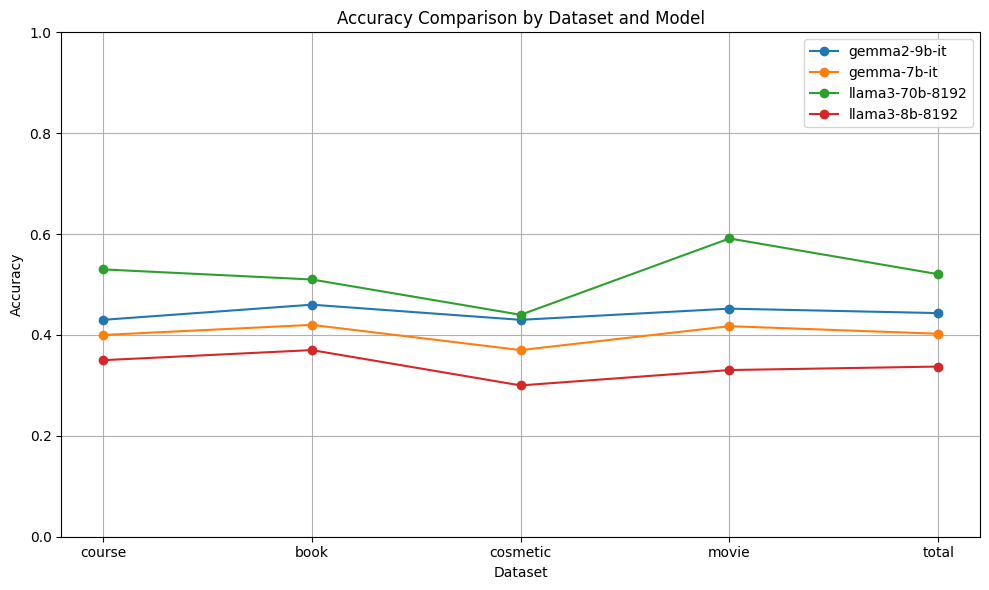

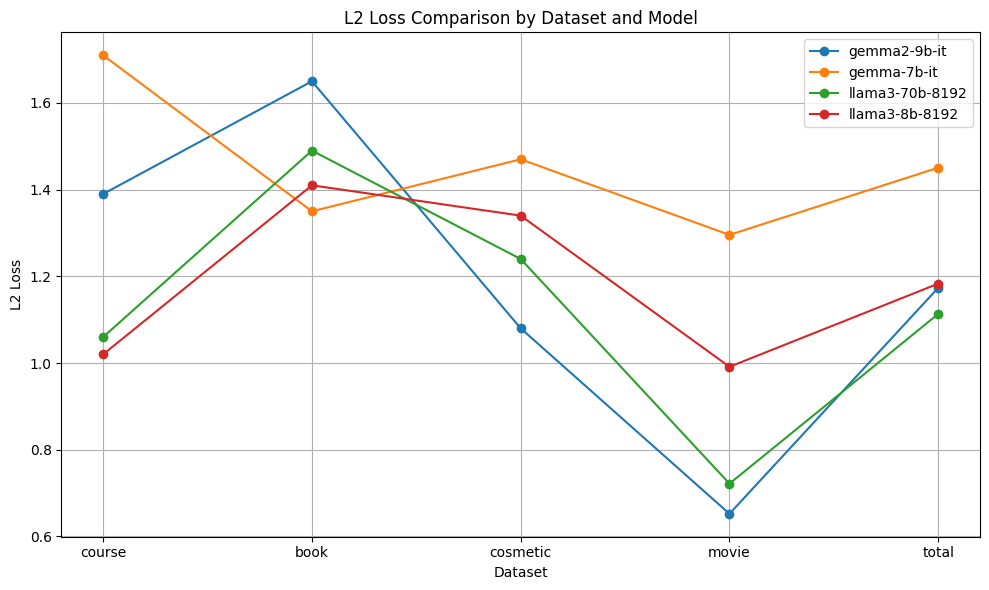

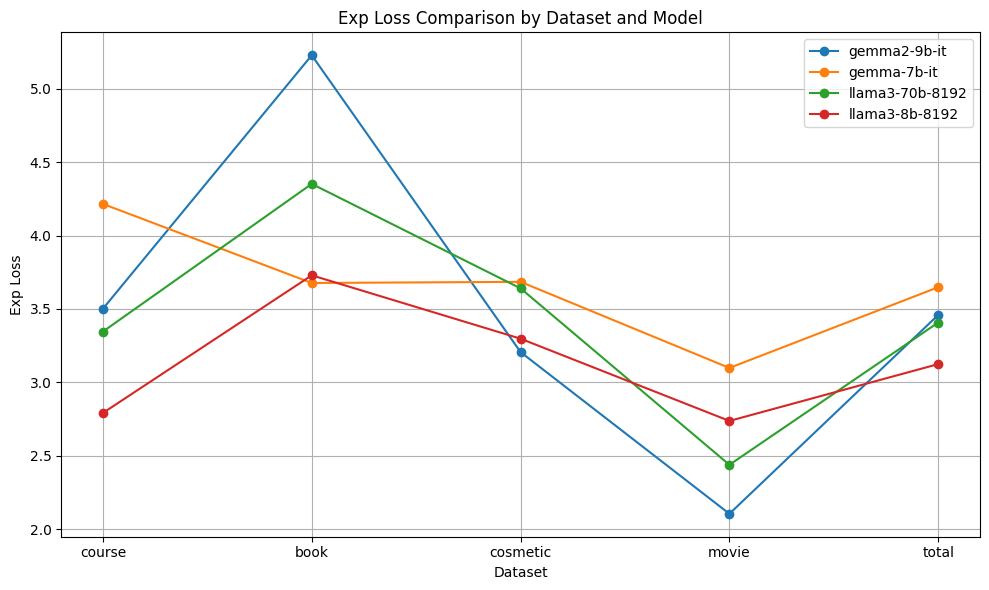

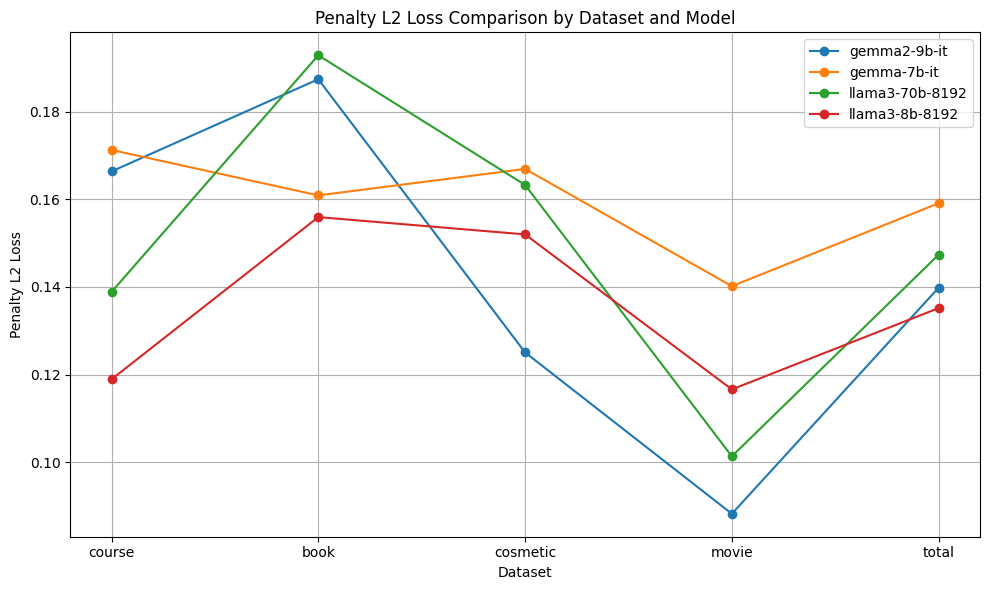

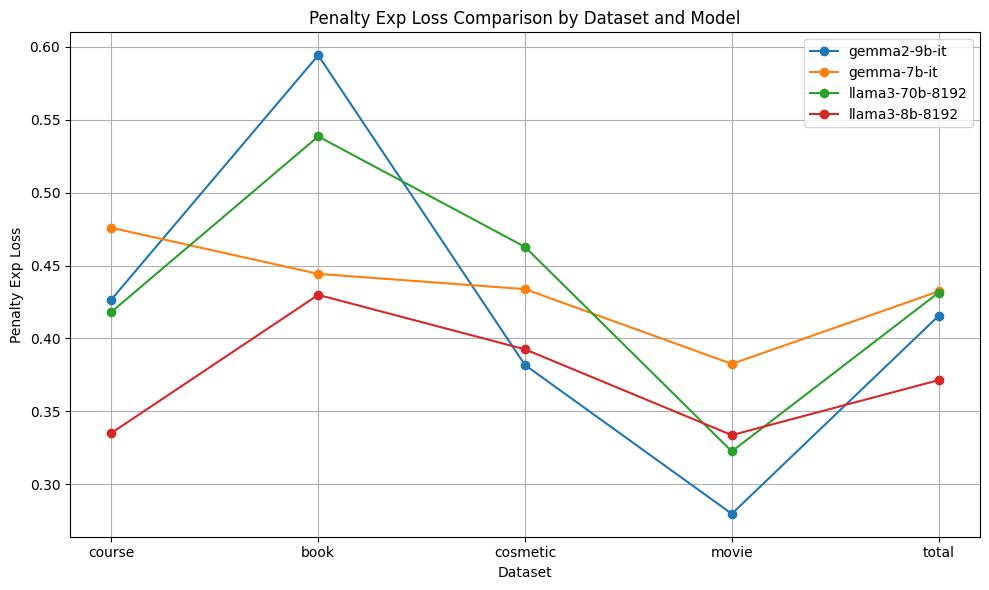

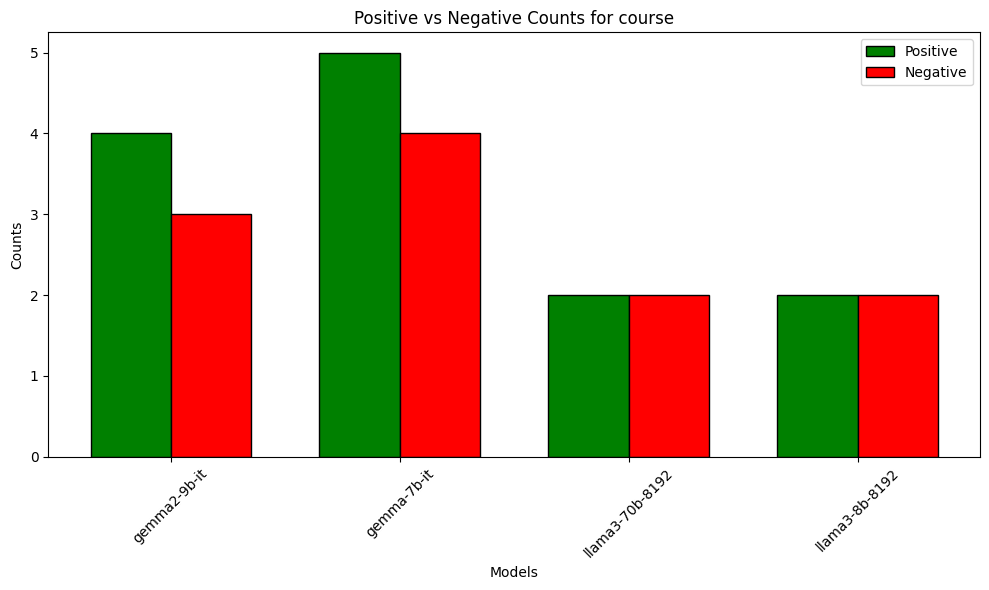

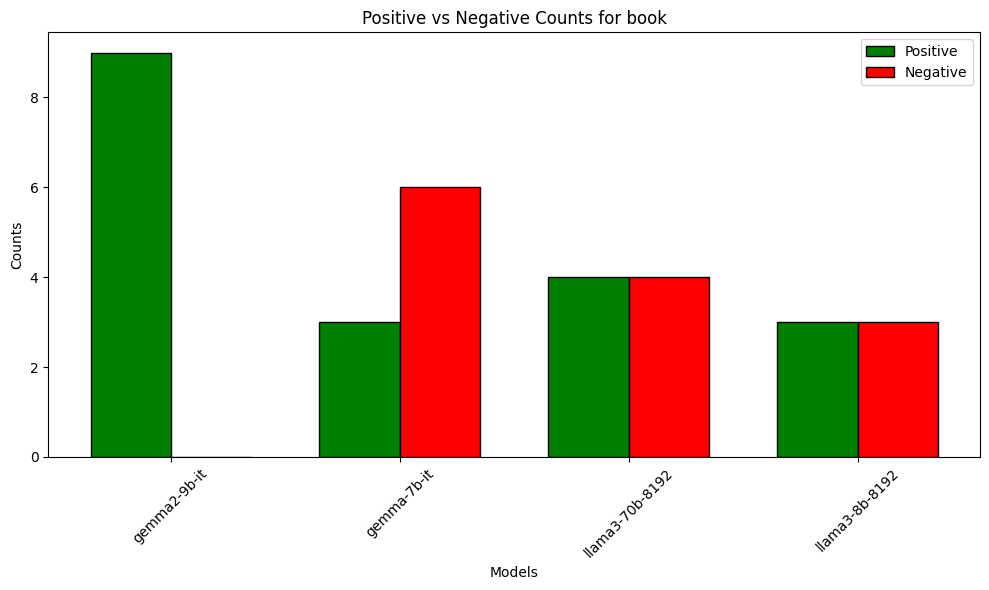

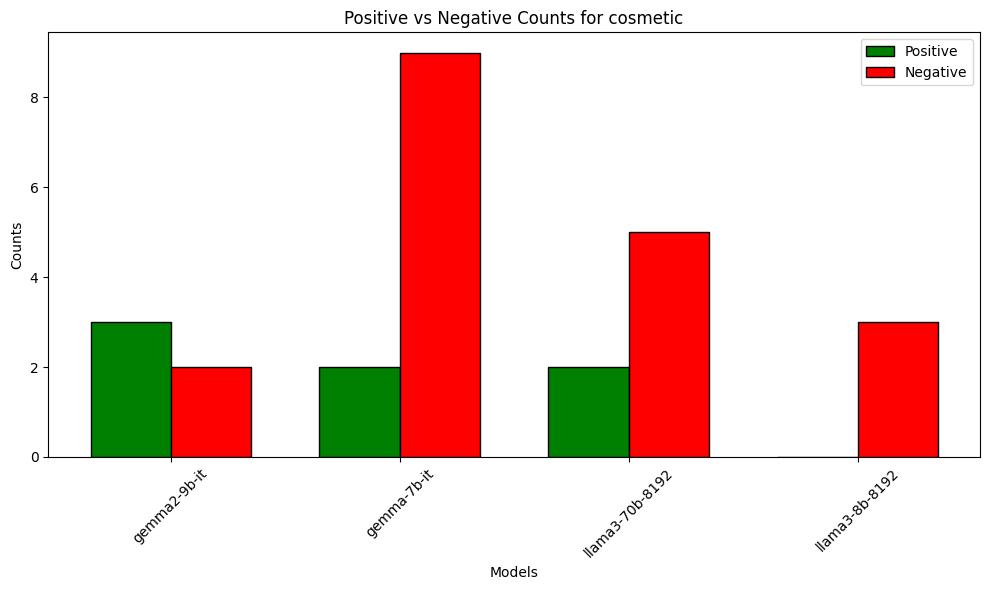

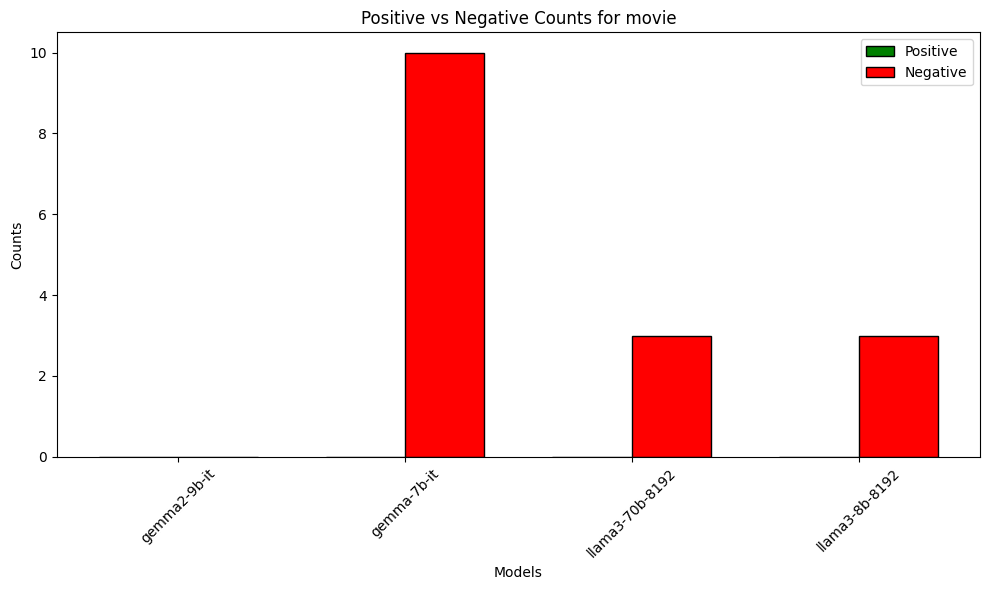

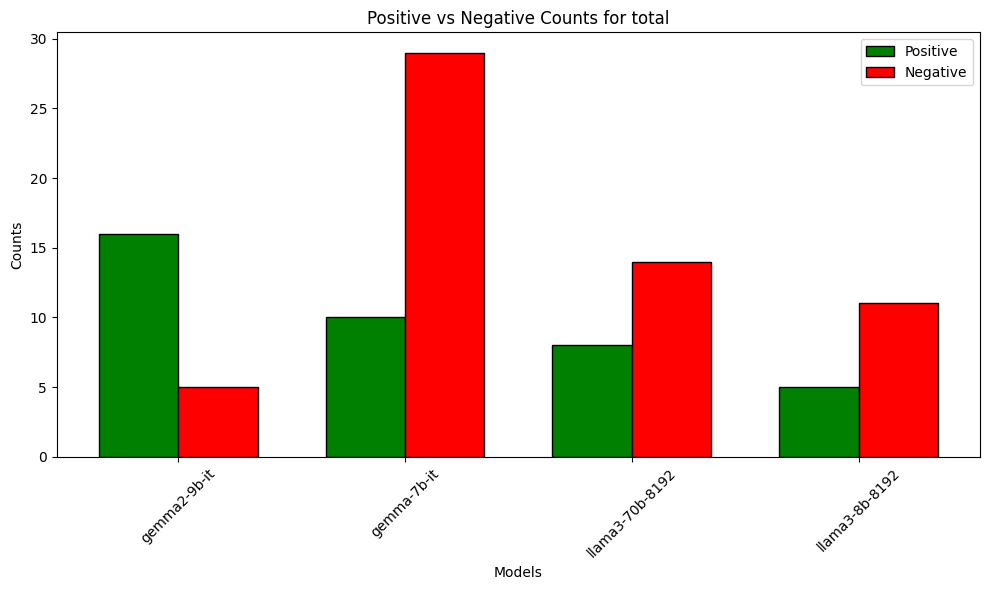

In [150]:
### 결과파일 로드
import json
import matplotlib.pyplot as plt
import numpy as np

result_json = ""
with open("result.json", "r") as f:
    result_json = f.read()

result = json.loads(result_json)

# Prepare data
datasets = dataName + ["total"] # Extract dataset names excluding "total"
# models = # Extract model names

# Plot 1: Accuracy comparison
plt.figure(figsize=(10, 6))
for model in models:
    acc_values = [result[model][dataset]["acc"] for dataset in datasets]
    plt.plot(datasets, acc_values, marker='o', label=model)

plt.title("Accuracy Comparison by Dataset and Model")
plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: L2 Loss comparison
plt.figure(figsize=(10, 6))
for model in models:
    l2_loss_values = [result[model][dataset]["l2_loss"] for dataset in datasets]
    plt.plot(datasets, l2_loss_values, marker='o', label=model)

plt.title("L2 Loss Comparison by Dataset and Model")
plt.xlabel("Dataset")
plt.ylabel("L2 Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Exp Loss comparison
plt.figure(figsize=(10, 6))
for model in models:
    exp_loss_values = [result[model][dataset]["exp_loss"] for dataset in datasets]
    plt.plot(datasets, exp_loss_values, marker='o', label=model)

plt.title("Exp Loss Comparison by Dataset and Model")
plt.xlabel("Dataset")
plt.ylabel("Exp Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 4: Penalty L2 Loss comparison
plt.figure(figsize=(10, 6))
for model in models:
    penalty_l2_loss_values = [result[model][dataset]["penalty_l2_loss"] for dataset in datasets]
    plt.plot(datasets, penalty_l2_loss_values, marker='o', label=model)

plt.title("Penalty L2 Loss Comparison by Dataset and Model")
plt.xlabel("Dataset")
plt.ylabel("Penalty L2 Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 5: Penalty Exp Loss comparison
plt.figure(figsize=(10, 6))
for model in models:
    penalty_exp_loss_values = [result[model][dataset]["penalty_exp_loss"] for dataset in datasets]
    plt.plot(datasets, penalty_exp_loss_values, marker='o', label=model)

plt.title("Penalty Exp Loss Comparison by Dataset and Model")
plt.xlabel("Dataset")
plt.ylabel("Penalty Exp Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

for dataset in datasets:
    plt.figure(figsize=(10, 6))
    
    x = np.arange(len(models))  # x-axis positions for models
    bar_width = 0.35  # Width of each bar
    
    posY = [result[model][dataset]["posY"] for model in models]
    negY = [result[model][dataset]["negY"] for model in models]
    
    # Plot posY and negY as side-by-side bars
    plt.bar(x - bar_width / 2, posY, width=bar_width, color='green', edgecolor='black', label='Positive')
    plt.bar(x + bar_width / 2, negY, width=bar_width, color='red', edgecolor='black', label='Negative')
    
    # Formatting and labels
    plt.xticks(x, models, rotation=45)  # Model names as x-axis labels
    plt.title(f"Positive vs Negative Counts for {dataset}")
    plt.ylabel("Counts")
    plt.xlabel("Models")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
def plot_candlestick(metric_key, ylabel, title):
    for dataset in datasets:
        plt.figure(figsize=(10, 6))
        x = np.arange(len(models))  # x-axis positions for models
        
        # Extract metric values for each model
        values = [result[model][dataset][metric_key] for model in models]
        
        # Plot as grouped bars
        plt.bar(x, values, color='blue', edgecolor='black', width=bar_width, label=metric_key.capitalize())
        
        # Formatting
        plt.xticks(x, models, rotation=45)
        plt.title(f"{title} for {dataset}")
        plt.ylabel(ylabel)
        plt.xlabel("Models")
        plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Zero reference line for context
        plt.legend()
        plt.tight_layout()
        plt.show()

def plot_candlestick_pos_neg():
    for dataset in datasets:
        plt.figure(figsize=(10, 6))
        x = np.arange(len(models))
        
        posY = [result[model][dataset]["posY"] for model in models]
        negY = [result[model][dataset]["negY"] for model in models]
        
        # Plot posY and negY as grouped bars
        plt.bar(x - bar_width / 2, posY, color='green', edgecolor='black', width=bar_width, label='Positive (posY)')
        plt.bar(x + bar_width / 2, negY, color='red', edgecolor='black', width=bar_width, label='Negative (negY)')
        
        # Formatting
        plt.xticks(x, models, rotation=45)
        plt.title(f"Positive vs Negative Counts for {dataset}")
        plt.ylabel("Counts")
        plt.xlabel("Models")
        plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Zero reference line
        plt.legend()
        plt.tight_layout()
        plt.show()


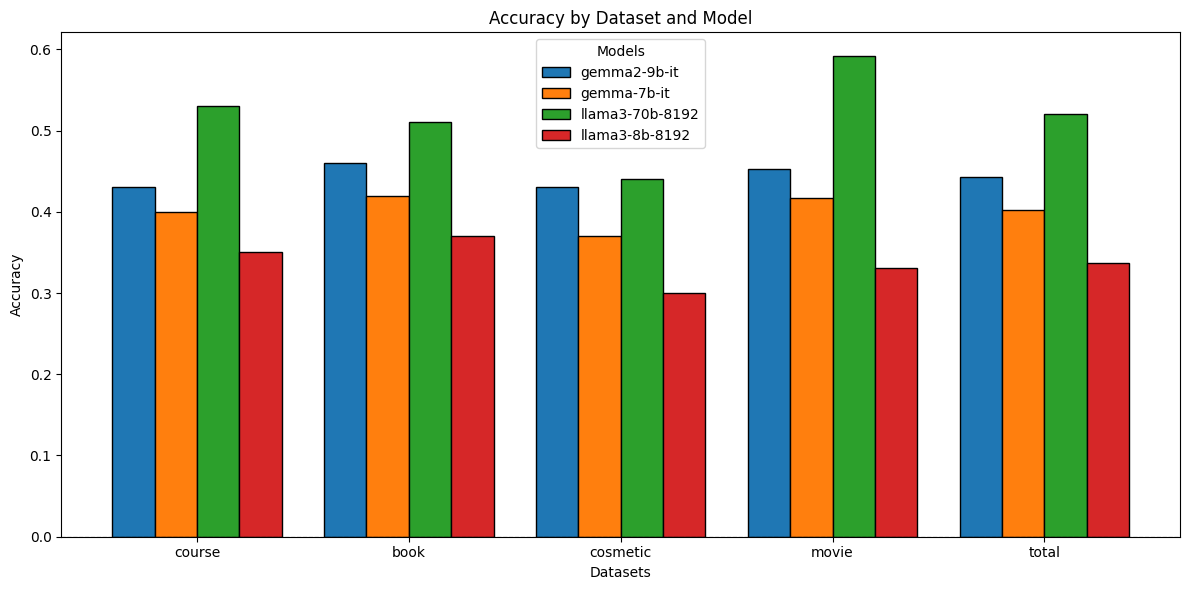

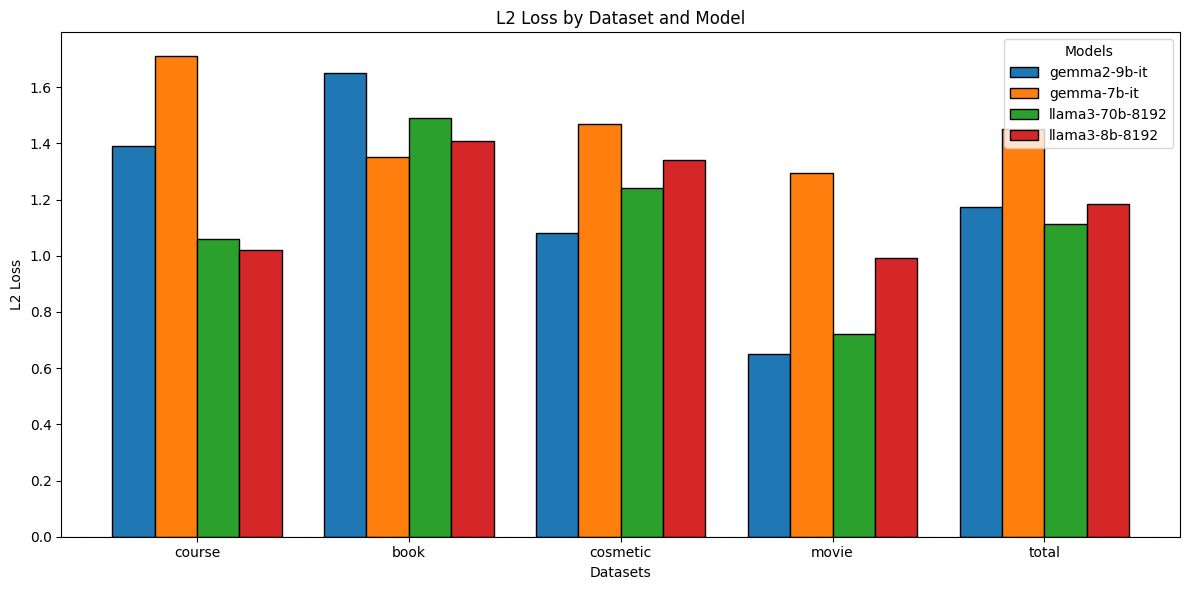

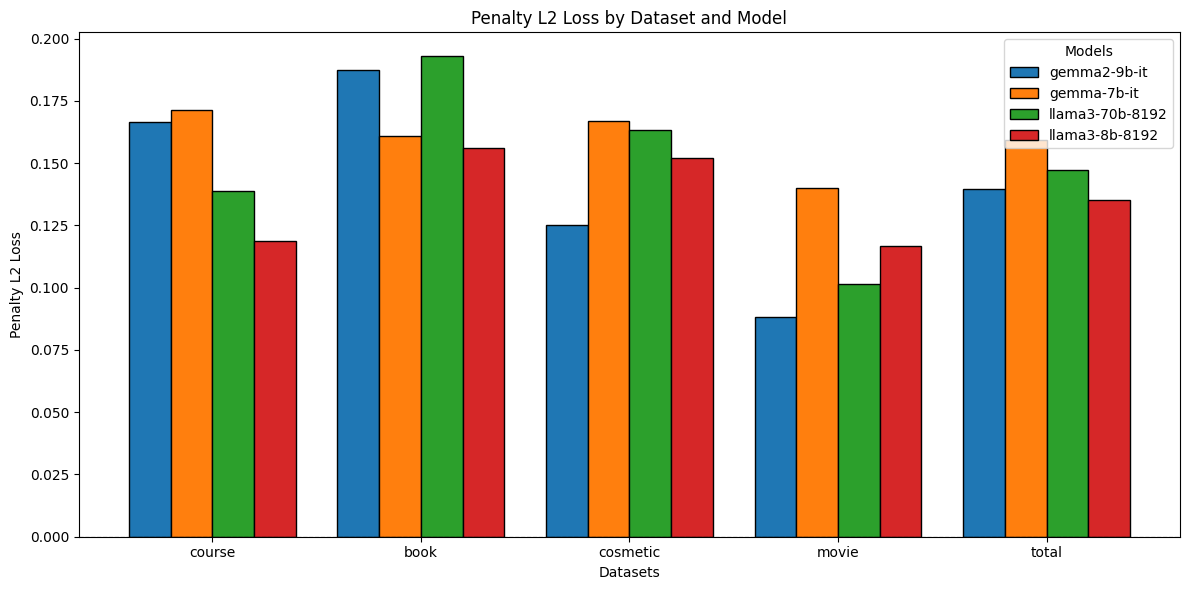

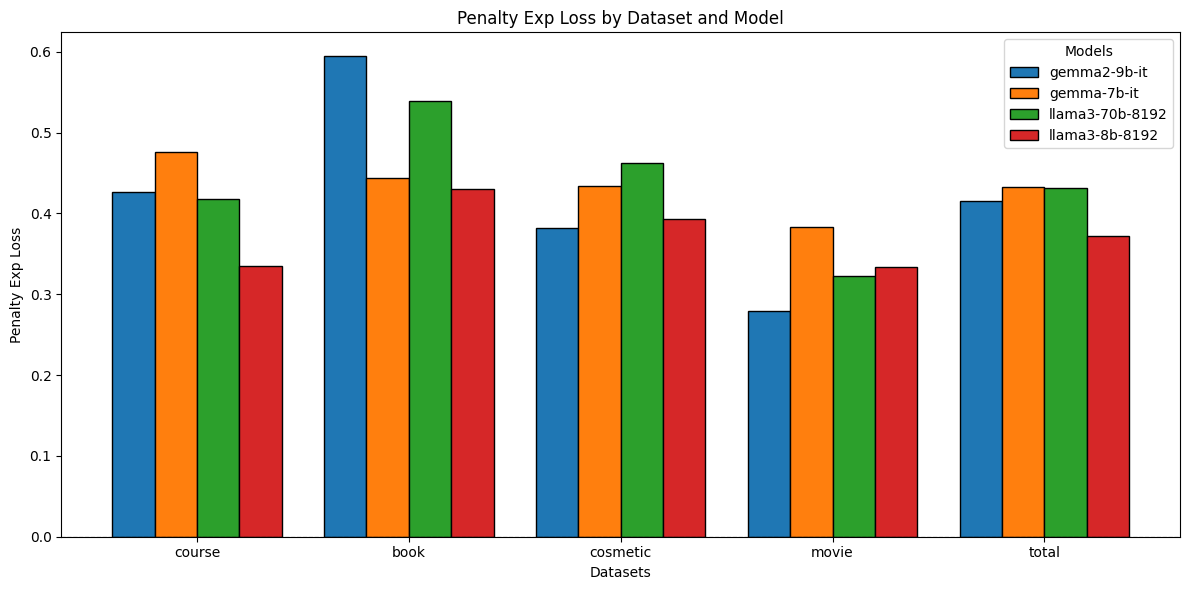

In [153]:
import matplotlib.pyplot as plt
import numpy as np

result_json = ""
with open("result.json", "r") as f:
    result_json = f.read()

result = json.loads(result_json)

# Prepare data
datasets = dataName + ["total"] # Extract dataset names excluding "total"
# models = # Extract model names

# Define metrics to plot
metrics = ["acc", "l2_loss", "penalty_l2_loss", "penalty_exp_loss"]
metric_labels = {
    "acc": "Accuracy",
    "l2_loss": "L2 Loss",
    "exp_loss": "Exp Loss",
    "penalty_l2_loss": "Penalty L2 Loss",
    "penalty_exp_loss": "Penalty Exp Loss",
}

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))
    x = np.arange(len(datasets))  # Positions for dataset groups
    bar_width = 0.2  # Width of each bar

    for i, model in enumerate(models):
        # Extract metric values for each dataset
        values = [result[model][dataset][metric] for dataset in datasets]

        # Plot bars for the current model
        plt.bar(
            x + i * bar_width, 
            values, 
            width=bar_width, 
            label=model, 
            edgecolor='black'
        )
    
    # Formatting
    plt.xticks(x + bar_width * (len(models) - 1) / 2, datasets)  # Center the tick labels
    plt.title(f"{metric_labels[metric]} by Dataset and Model")
    plt.xlabel("Datasets")
    plt.ylabel(metric_labels[metric])
    plt.legend(title="Models")
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Zero reference line
    plt.tight_layout()
    plt.show()


